In [1]:
library(limma)
library(survival)
library(survminer)
library(msigdbr)
library(clusterProfiler)
library(enrichplot)
library(ComplexHeatmap)
library(GSVA)
library(reshape2)

TCGA_PanCancer = readRDS("/srv/shiny-server/SNVIO_V10.1/data/TCGA/panacanlt_TCGA_log2.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

Loading required package: ggplot2

Loading required package: ggpubr



Bioconductor version '3.12' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘enrichplot’


The following object is masked from ‘package:ggpubr’:

    color_palette


Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: htt

In [2]:
TCGA_cohort_cal_pm = function(TCGA,cancer_type,gene,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

In [4]:
anno = vector()
Complement_Mut_matrix = NA
Complement_Wt_matrix = NA
for(i in setdiff(names(TCGA_PanCancer),c("DLBC","LAML"))){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION","All","Others")
    RNA_ID = colnames(TCGA_PanCancer[[i]]$rna)
    tmp_mut = intersect(tmp_cohort$mut,RNA_ID)
    tmp_wt = intersect(tmp_cohort$wt,RNA_ID)
    Complement_Mut_matrix = cbind(Complement_Mut_matrix,TCGA_PanCancer[[i]]$rna[tmp_mut])
    Complement_Wt_matrix = cbind(Complement_Wt_matrix,TCGA_PanCancer[[i]]$rna[tmp_wt])
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL

Complement_Mut_matrix$Complement_Mut_matrix = NULL
Complement_Wt_matrix$Complement_Wt_matrix = NULL

In [5]:
All_RNA = cbind(Complement_Mut_matrix,Complement_Wt_matrix)

In [7]:
ncol(All_RNA)

[1] 9410

### GSEA

In [6]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]

In [7]:
group = factor(c(rep("Mutation",ncol(Complement_Mut_matrix)),rep("Wildtype",ncol(Complement_Wt_matrix))),levels = c("Mutation","Wildtype"))
design = model.matrix(~0+group)
rownames(design) = colnames(tmp_data)
colnames(design) = c("Mutation","Wildtype")
  
fit = lmFit(tmp_data,design)
contr = makeContrasts(Mutation-Wildtype,levels = design)
diff = contrasts.fit(fit,contr)
diff = eBayes(diff)
tab = topTable(diff, sort.by = "P", n = Inf)

#

In [93]:
FC = tab$logFC
names(FC) = rownames(tab)
FC = sort(FC,decreasing = T)

In [94]:
KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_CC = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:CC") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_MF = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:MF") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [95]:
res = GSEA(geneList = FC,TERM2GENE = GO_BP[,c(1,3)],pvalueCutoff = 1)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [31]:
x2 <- pairwise_termsim(res,showCategory = 100)
p = emapplot(x2,showCategory = 100,color="NES",min_edge = 0.25,layout = "fr")

Warning message:
“ggrepel: 56 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


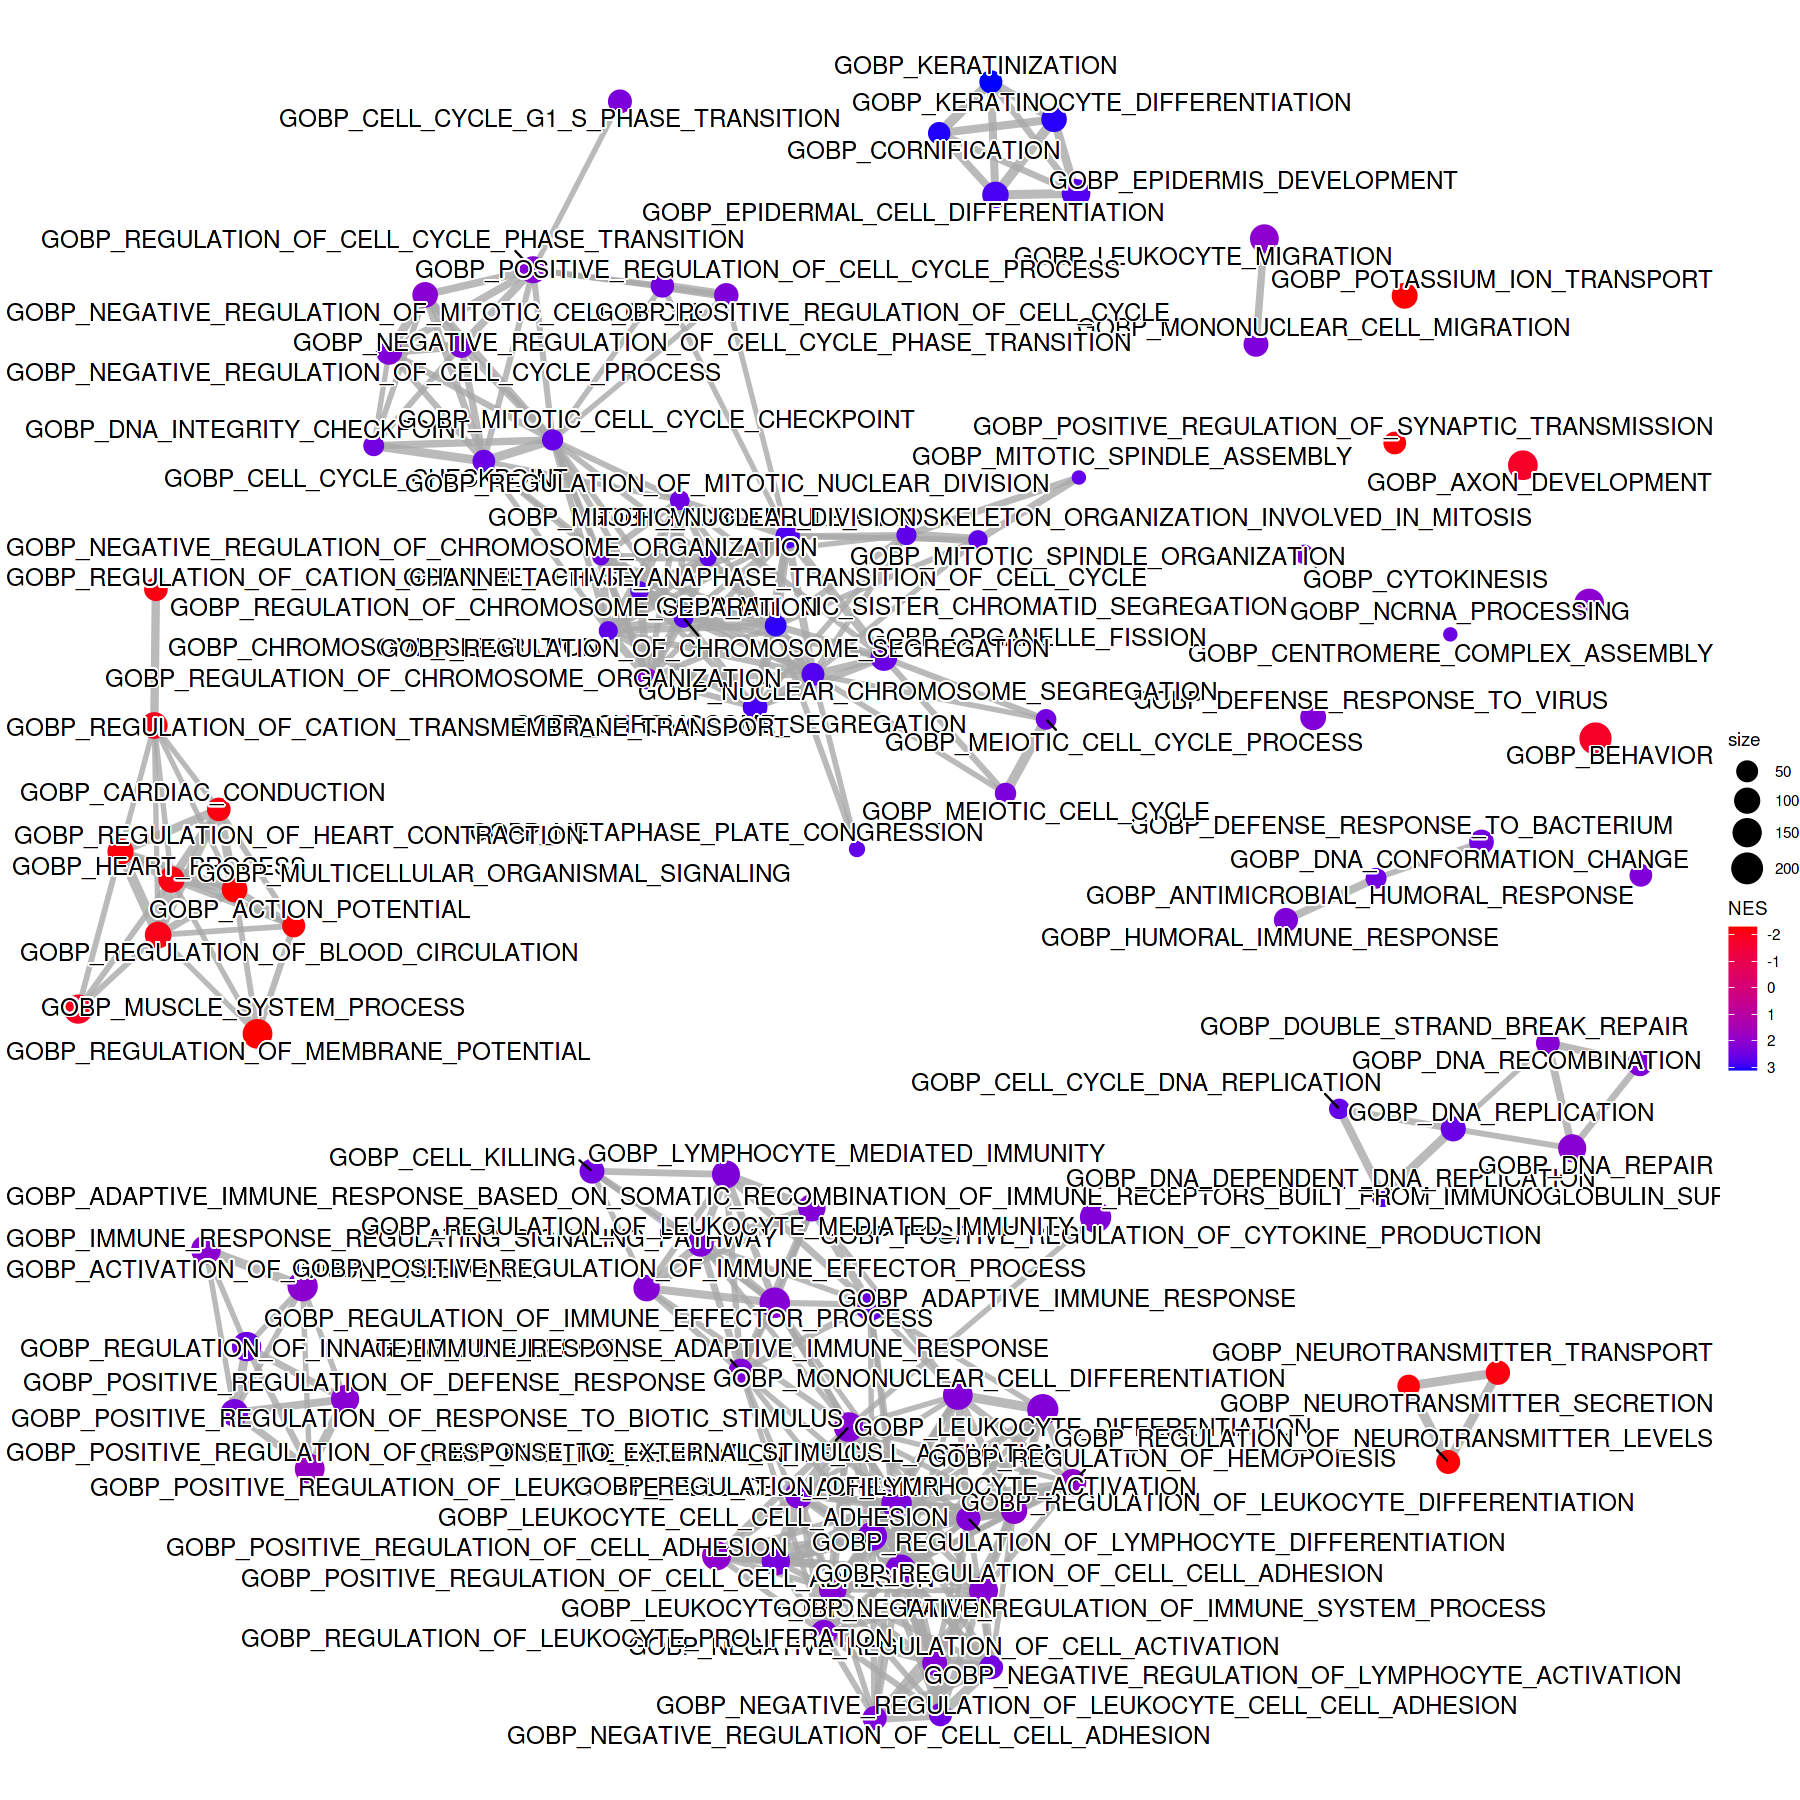

In [32]:
options(repr.plot.height = 15, repr.plot.width = 15)
p

In [36]:
p_name = p$data$name
p$data$name =p$data$`.ggraph.orig_index`

p$layers[[2]]$aes_params$shape = 21

p$layers[[2]]$mapping = aes(x = x, y = y,size = size,fill = color)
p = p+scale_fill_gradient2(low = "blue",high = "red",mid = "white")+labs(fill="NES")

p$data$name = NA
p$layers[[1]]$aes_params$edge_alpha = 0.3

Warning message:
“Removed 100 rows containing missing values (geom_text_repel).”


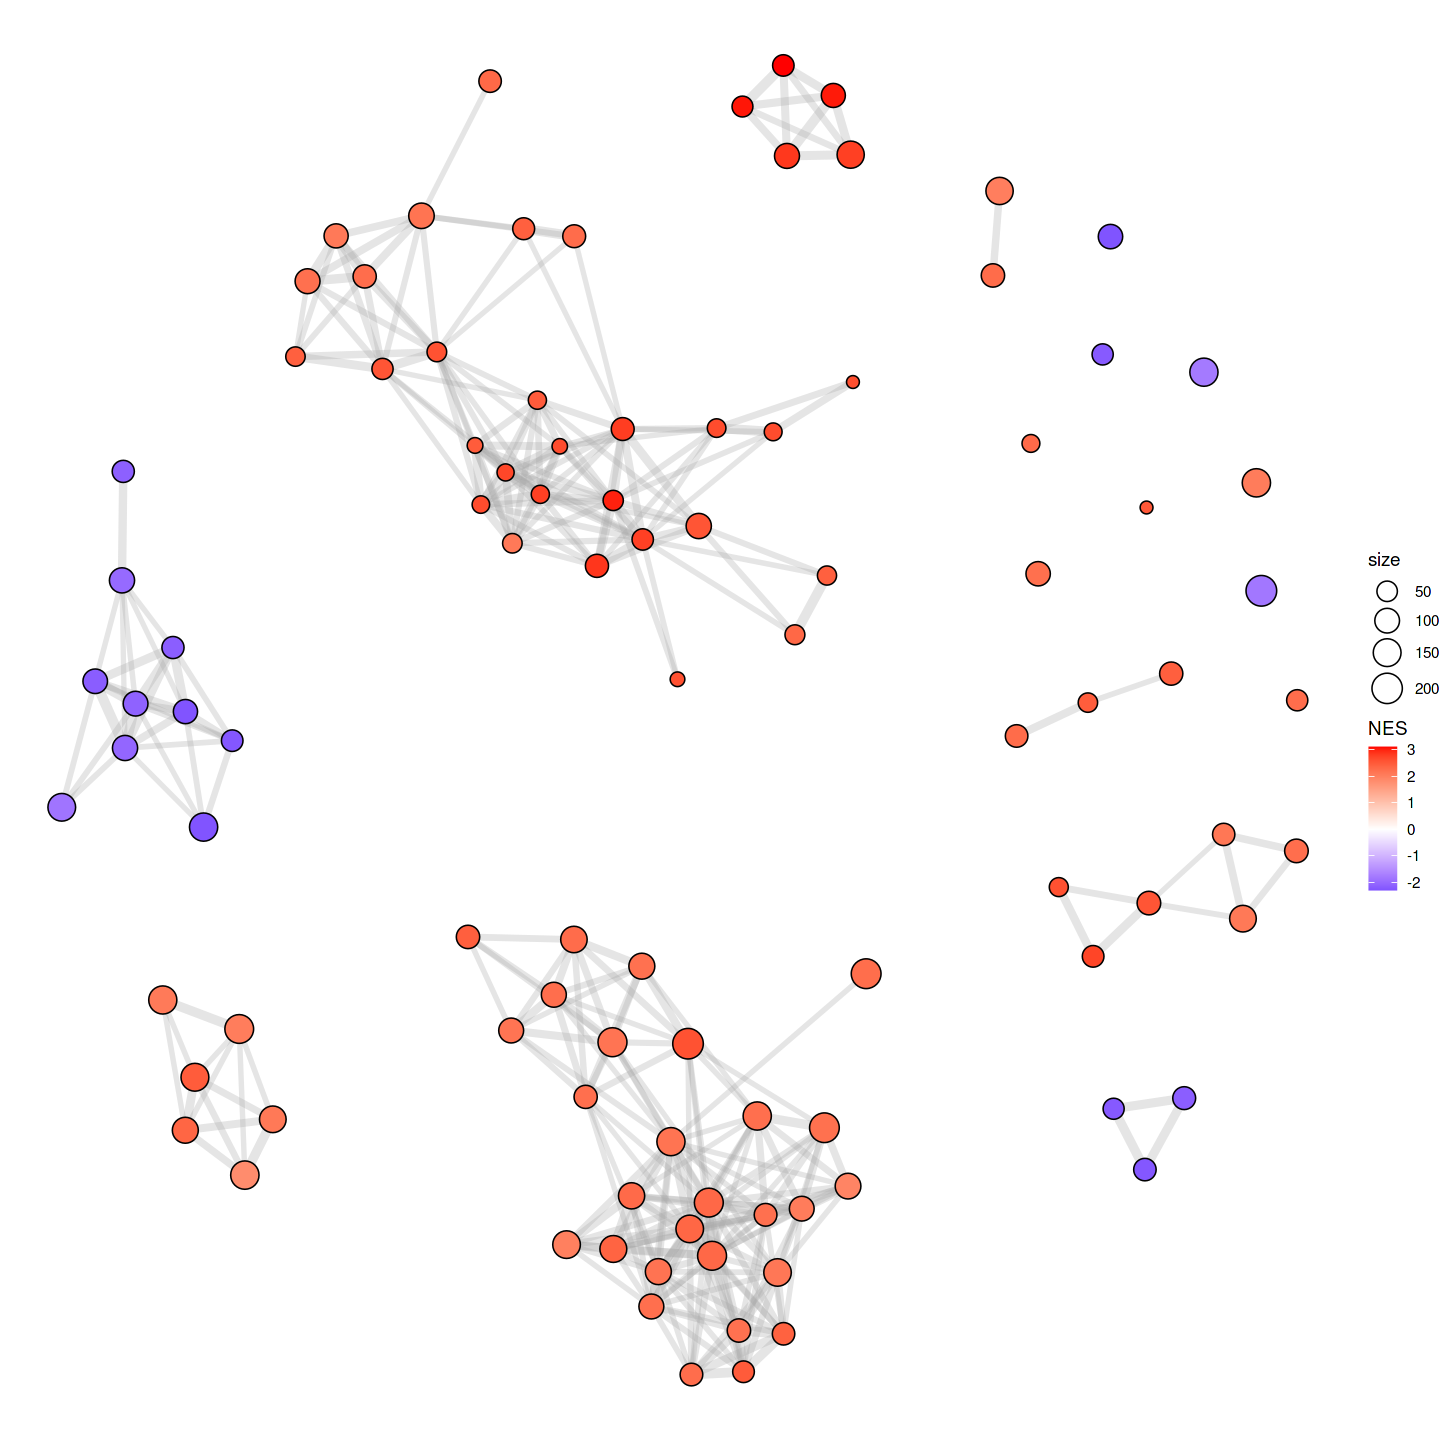

In [38]:
options(repr.plot.height = 12, repr.plot.width = 12)
p

In [39]:
pdf("Artical_Figure2/Figure 3/GSEA_Network.pdf",width = 10,height = 10)
p
dev.off()

Warning message:
“Removed 100 rows containing missing values (geom_text_repel).”


png 
  2

In [40]:
write.table(res@result[1:100,],file = "GSEA_PanCancer.txt",sep = "\t",row.names = F,col.names = T,quote = F)

In [41]:
library(ggplot2)
library(RColorBrewer)
library(grid)
gsInfo <- function(object, geneSetID) {
    geneList <- object@geneList

    if (is.numeric(geneSetID))
        geneSetID <- object@result[geneSetID, "ID"]

    geneSet <- object@geneSets[[geneSetID]]
    exponent <- object@params[["exponent"]]
    df <- gseaScores(geneList, geneSet, exponent, fortify=TRUE)
    df$ymin <- 0
    df$ymax <- 0
    pos <- df$position == 1
    h <- diff(range(df$runningScore))/20
    df$ymin[pos] <- -h
    df$ymax[pos] <- h
    df$geneList <- geneList

    df$Description <- object@result[geneSetID, "Description"]
    return(df)
}
gseaScores <- getFromNamespace("gseaScores", "DOSE")

tableGrob2 <- function(d, p = NULL) {
    # has_package("gridExtra")
    d <- d[order(rownames(d)),]
    tp <- gridExtra::tableGrob(d,theme = gridExtra::ttheme_default(base_size = 20))
    if (is.null(p)) {
        return(tp)
    }

    # Fix bug: The 'group' order of lines and dots/path is different
    p_data <- ggplot_build(p)$data[[1]]
    # pcol <- unique(ggplot_build(p)$data[[1]][["colour"]])
    p_data <- p_data[order(p_data[["group"]]), ]
    pcol <- unique(p_data[["colour"]])
    ## This is fine too
    ## pcol <- unique(p_data[["colour"]])[unique(p_data[["group"]])]  
    j <- which(tp$layout$name == "rowhead-fg")

    for (i in seq_along(pcol)) {
        tp$grobs[j][[i+1]][["gp"]] <- gpar(col = pcol[i])
    }
    return(tp)
}

my_gseaplot2 = function (x, geneSetID, title = "",self.Description = geneSetID, color = "green", base_size = 11, 
    rel_heights = c(1.5, 0.5, 1), subplots = 1:3, pvalue_table = FALSE, title.size=28,
    ES_geom = "line") 
{
    ES_geom <- match.arg(ES_geom, c("line", "dot"))
    geneList <- position <- NULL
    if (length(geneSetID) == 1) {
        gsdata <- gsInfo(x, geneSetID)
    }
    else {
        gsdata <- do.call(rbind, lapply(geneSetID, gsInfo, object = x))
    }
    p <- ggplot(gsdata, aes_(x = ~x)) + xlab(NULL) + theme_classic(base_size) + 
        theme(panel.grid.major = element_line(colour = "grey92"), 
            panel.grid.minor = element_line(colour = "grey92"), 
            panel.grid.major.y = element_blank(), panel.grid.minor.y = element_blank()) + 
        scale_x_continuous(expand = c(0, 0))
    if (ES_geom == "line") {
        es_layer <- geom_line(aes_(y = ~runningScore, color = ~Description), 
            size = 1)
    }
    else {
        es_layer <- geom_point(aes_(y = ~runningScore, color = ~Description), 
            size = 1, data = subset(gsdata, position == 1))
    }
    p.res <- p + es_layer + theme(legend.position = c(0.8, 0.8), 
        legend.title = element_blank(), legend.background = element_rect(fill = "transparent"))
    p.res <- p.res + ylab("Running Enrichment Score") + theme(axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(), axis.line.x = element_blank(), 
        plot.margin = margin(t = 0.2, r = 0.2, b = 0, l = 0.2, 
            unit = "cm"))
    i <- 0
    for (term in unique(gsdata$Description)) {
        idx <- which(gsdata$ymin != 0 & gsdata$Description == 
            term)
        gsdata[idx, "ymin"] <- i
        gsdata[idx, "ymax"] <- i + 1
        i <- i + 1
    }
    p2 <- ggplot(gsdata, aes_(x = ~x)) + geom_linerange(aes_(ymin = ~ymin, 
        ymax = ~ymax, color = ~Description)) + xlab(NULL) + ylab(NULL) + 
        theme_classic(base_size) + theme(legend.position = "none", 
        plot.margin = margin(t = -0.1, b = 0, unit = "cm"), axis.ticks = element_blank(), 
        axis.text = element_blank(), axis.line.x = element_blank()) + 
        scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 
        0))
    if (length(geneSetID) == 1) {
        v <- seq(1, sum(gsdata$position), length.out = 9)
        inv <- findInterval(rev(cumsum(gsdata$position)), v)
        if (min(inv) == 0) 
            inv <- inv + 1
        col <- c(rev(brewer.pal(5, "Blues")), brewer.pal(5, "Reds"))
        ymin <- min(p2$data$ymin)
        yy <- max(p2$data$ymax - p2$data$ymin) * 0.3
        xmin <- which(!duplicated(inv))
        xmax <- xmin + as.numeric(table(inv)[as.character(unique(inv))])
        d <- data.frame(ymin = ymin, ymax = yy, xmin = xmin, 
            xmax = xmax, col = col[unique(inv)])
        p2 <- p2 + geom_rect(aes_(xmin = ~xmin, xmax = ~xmax, 
            ymin = ~ymin, ymax = ~ymax, fill = ~I(col)), data = d, 
            alpha = 0.9, inherit.aes = FALSE)
    }
    df2 <- p$data
    df2$y <- p$data$geneList[df2$x]
    p.pos <- p + geom_segment(data = df2, aes_(x = ~x, xend = ~x, 
        y = ~y, yend = 0), color = "grey")
    p.pos <- p.pos + ylab("Ranked List Metric") + xlab("Rank in Ordered Dataset") + 
        theme(plot.margin = margin(t = -0.1, r = 0.2, b = 0.2, l = 0.2, unit = "cm"),
              axis.title = element_text(face = "bold",size = 18),
              axis.text = element_text(size = 15))
    if (!is.null(title) && !is.na(title) && title != "") 
        p.res <- p.res + ggtitle(title)+theme(plot.title = element_text(hjust = 0.5,size = title.size,face = "bold"),
                                              axis.text.y = element_text(size = 15),
                                              axis.title.y = element_text(face = "bold",size = 18),)
    if (length(color) == length(geneSetID)) {
        p.res <- p.res + scale_color_manual(values = color)
        if (length(color) == 1) {
            p.res <- p.res + theme(legend.position = "none")
            p2 <- p2 + scale_color_manual(values = "black")
        }
        else {
            p2 <- p2 + scale_color_manual(values = color)
        }
    }
    if (pvalue_table) {
        pd <- x[geneSetID, c("Description", "pvalue", "p.adjust")]
        rownames(pd) <- self.Description
        pd <- pd[, -1]
        pd <- round(pd, 4)
        tp <- tableGrob2(pd, p.res)
        p.res <- p.res + theme(legend.position = "none") + annotation_custom(tp,
            xmin = quantile(p.res$data$x, 0.5), xmax = quantile(p.res$data$x, 
                0.95), ymin = quantile(p.res$data$runningScore, 
                0.6), ymax = quantile(p.res$data$runningScore, 
                0.8))
    }
    plotlist <- list(p.res, p2, p.pos)[subplots]
    n <- length(plotlist)
    plotlist[[n]] <- plotlist[[n]] + theme(axis.line.x = element_line(), 
        axis.ticks.x = element_line(), axis.text.x = element_text())
    if (length(subplots) == 1) 
        return(plotlist[[1]] + theme(plot.margin = margin(t = 0.2, 
            r = 0.2, b = 0.2, l = 0.2, unit = "cm")))
    if (length(rel_heights) > length(subplots)) 
        rel_heights <- rel_heights[subplots]
    plot_grid(plotlist = plotlist, ncol = 1, align = "v", rel_heights = rel_heights)
}

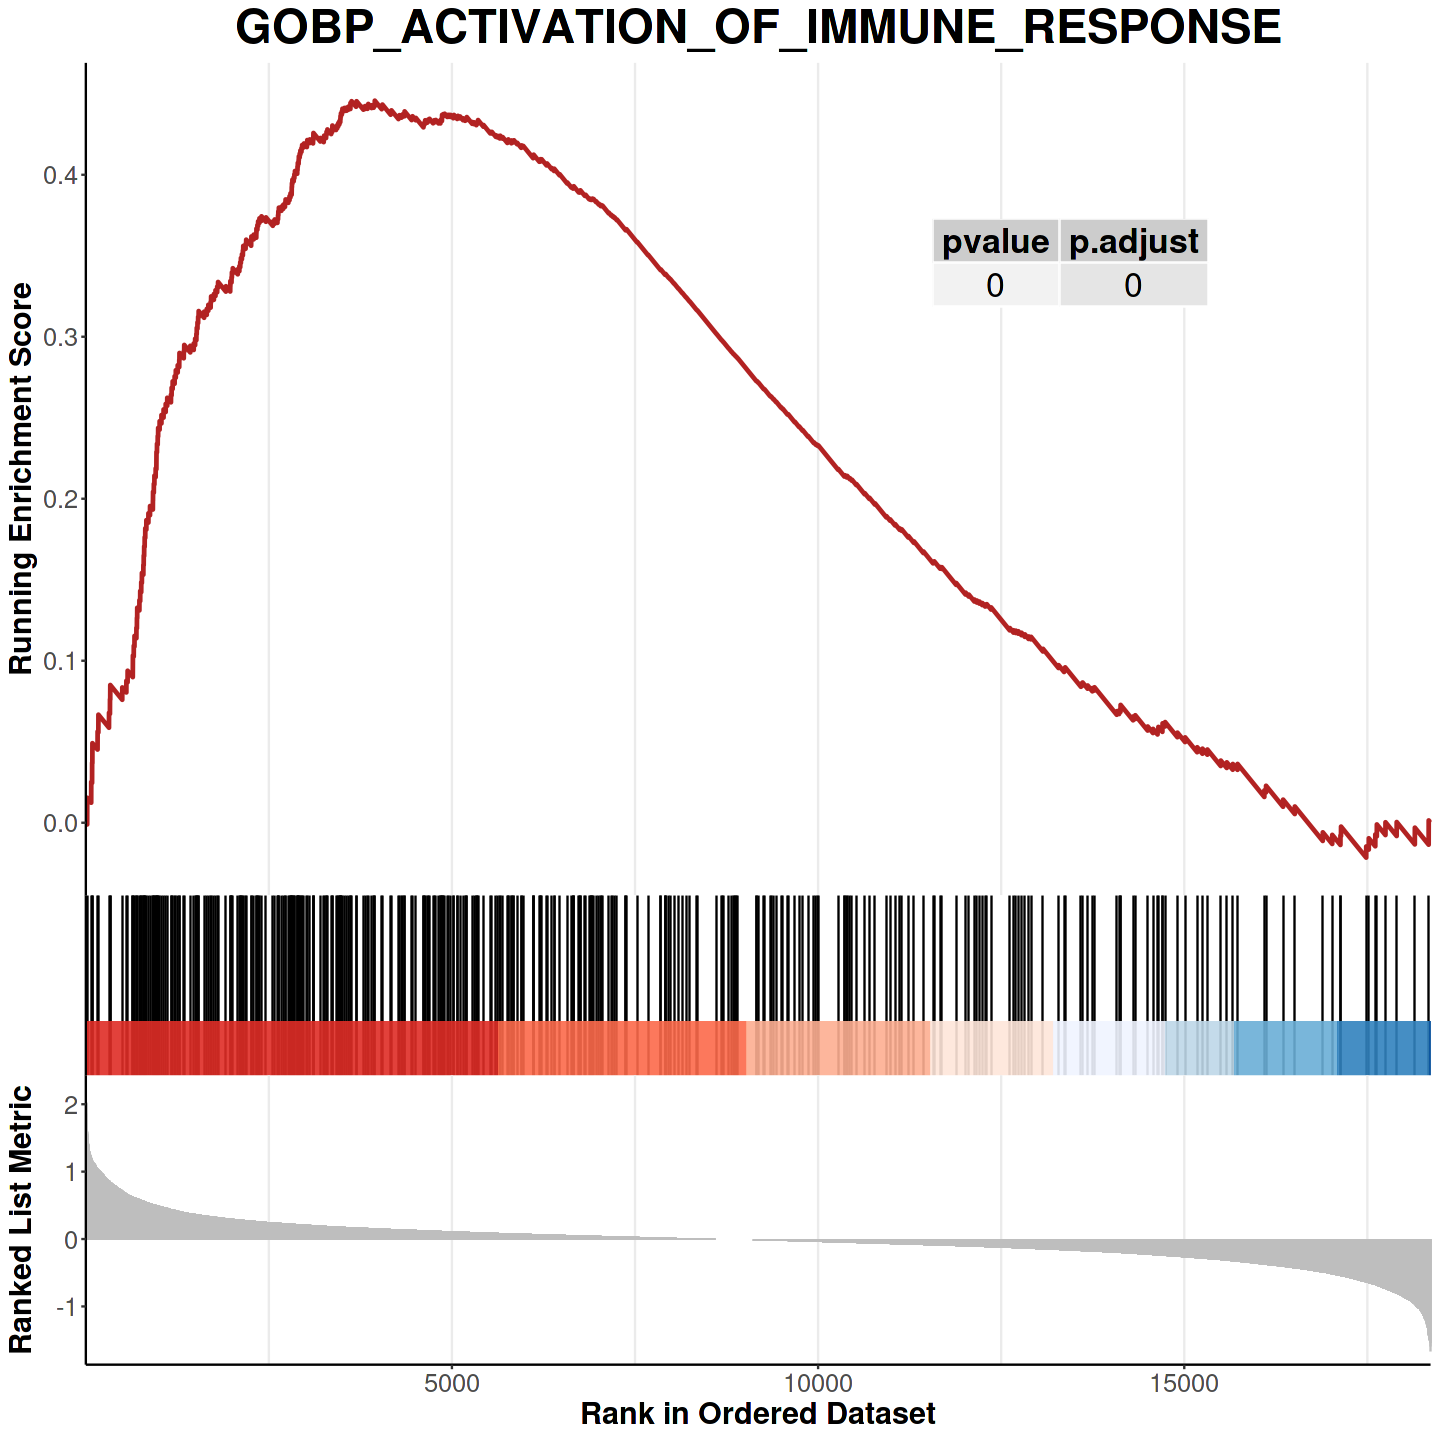

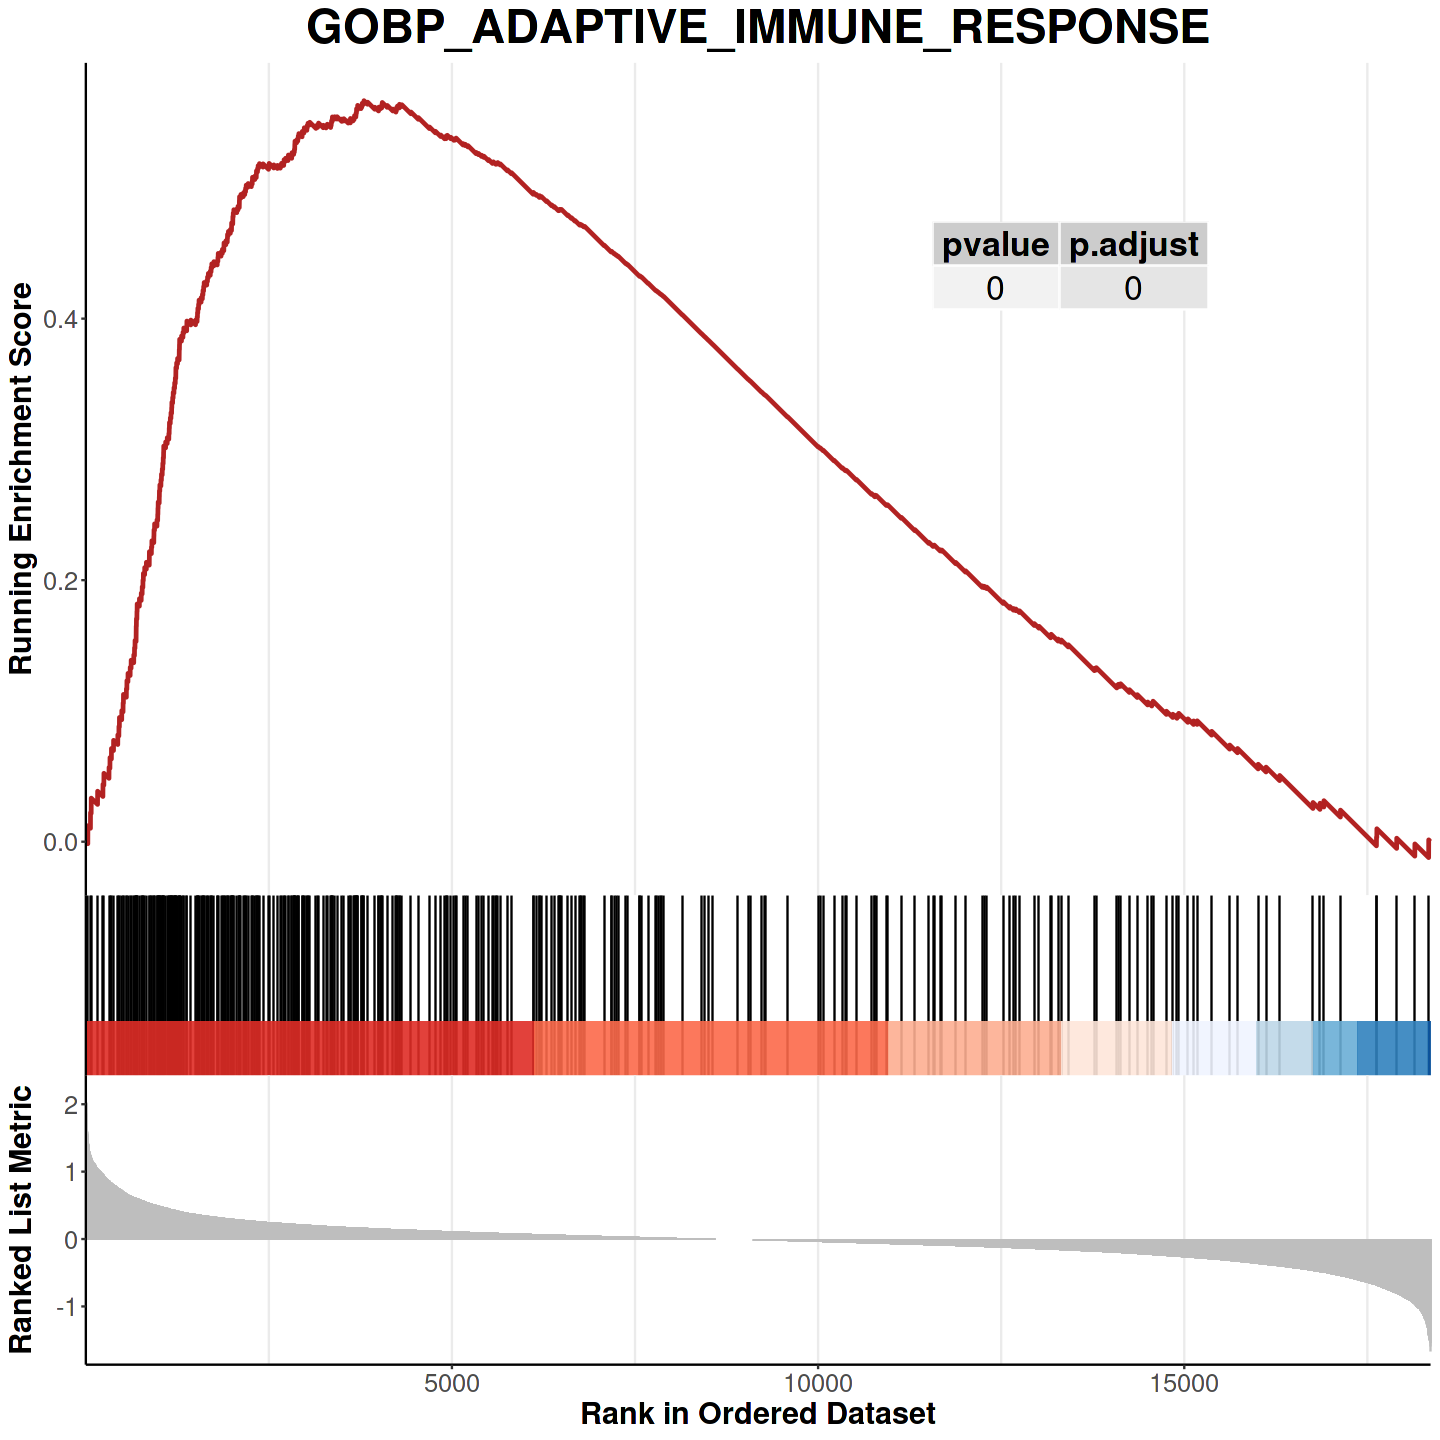

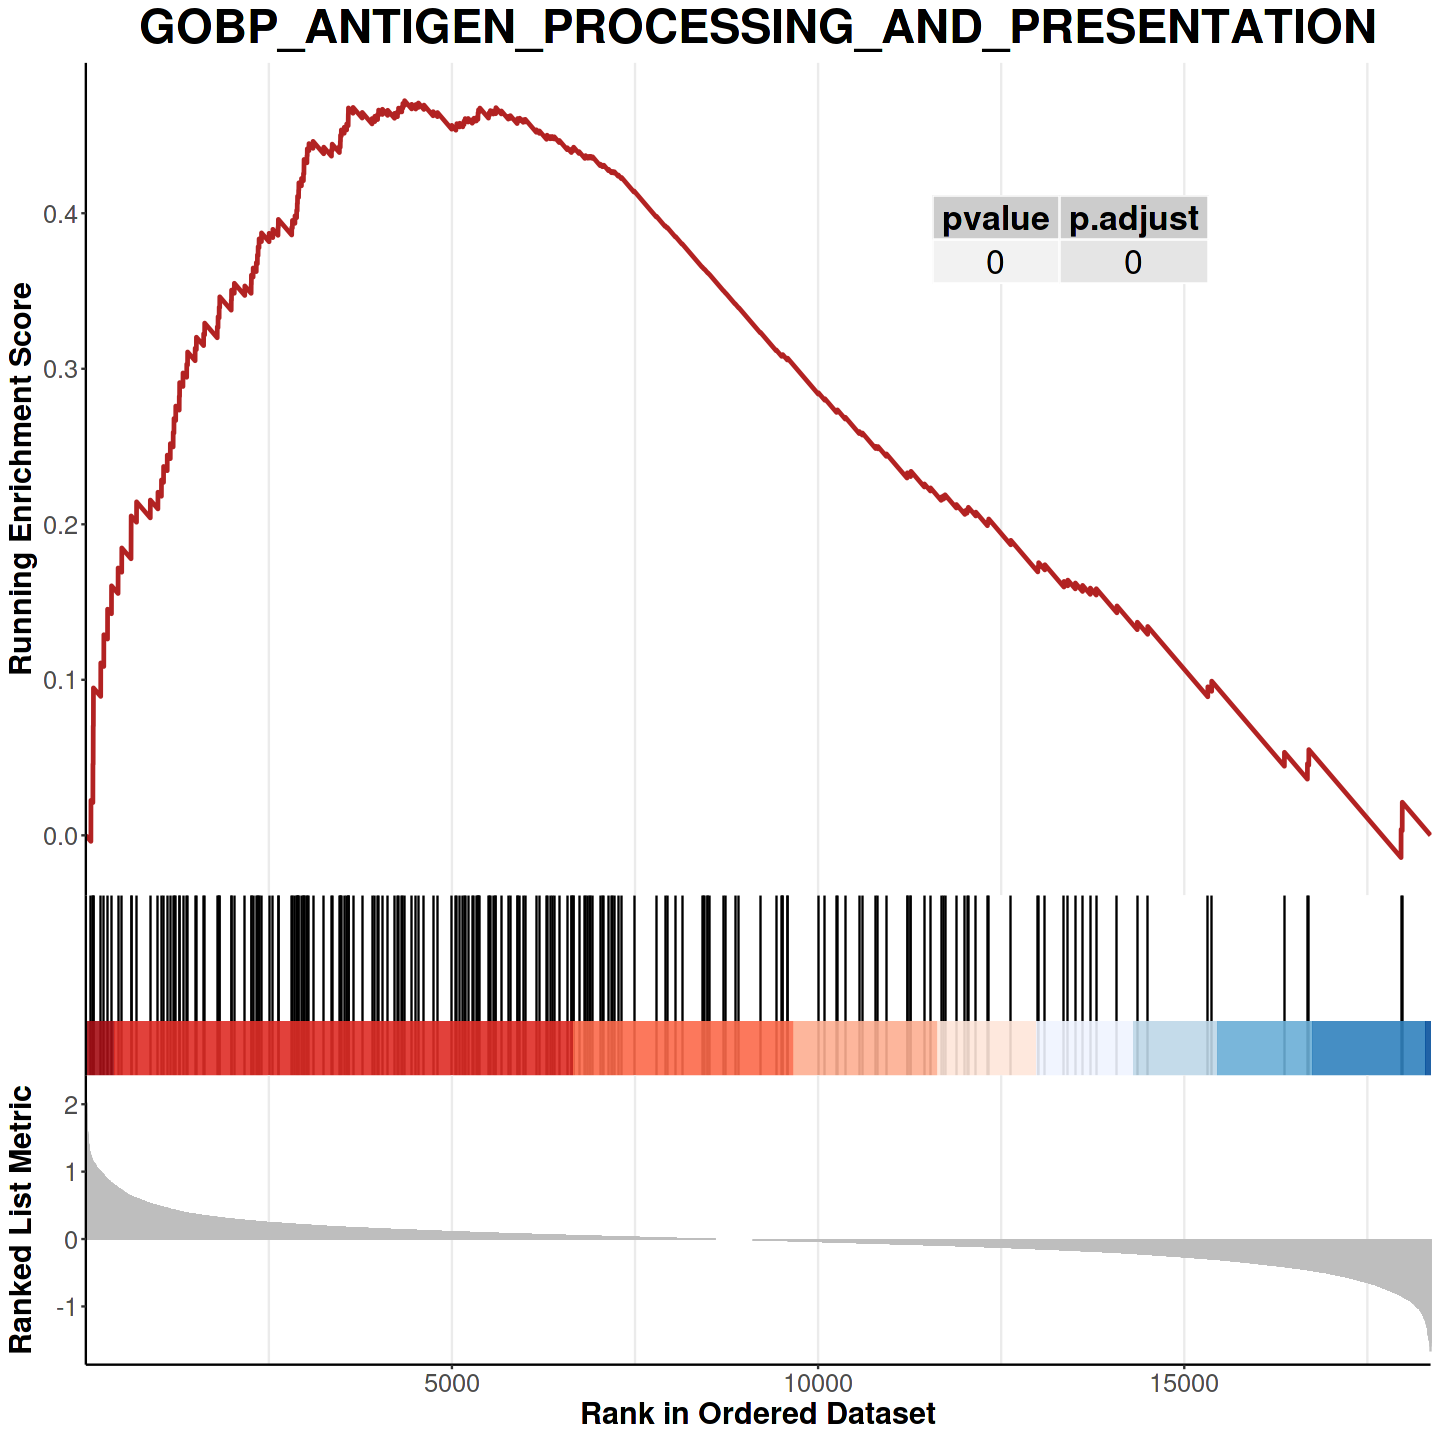

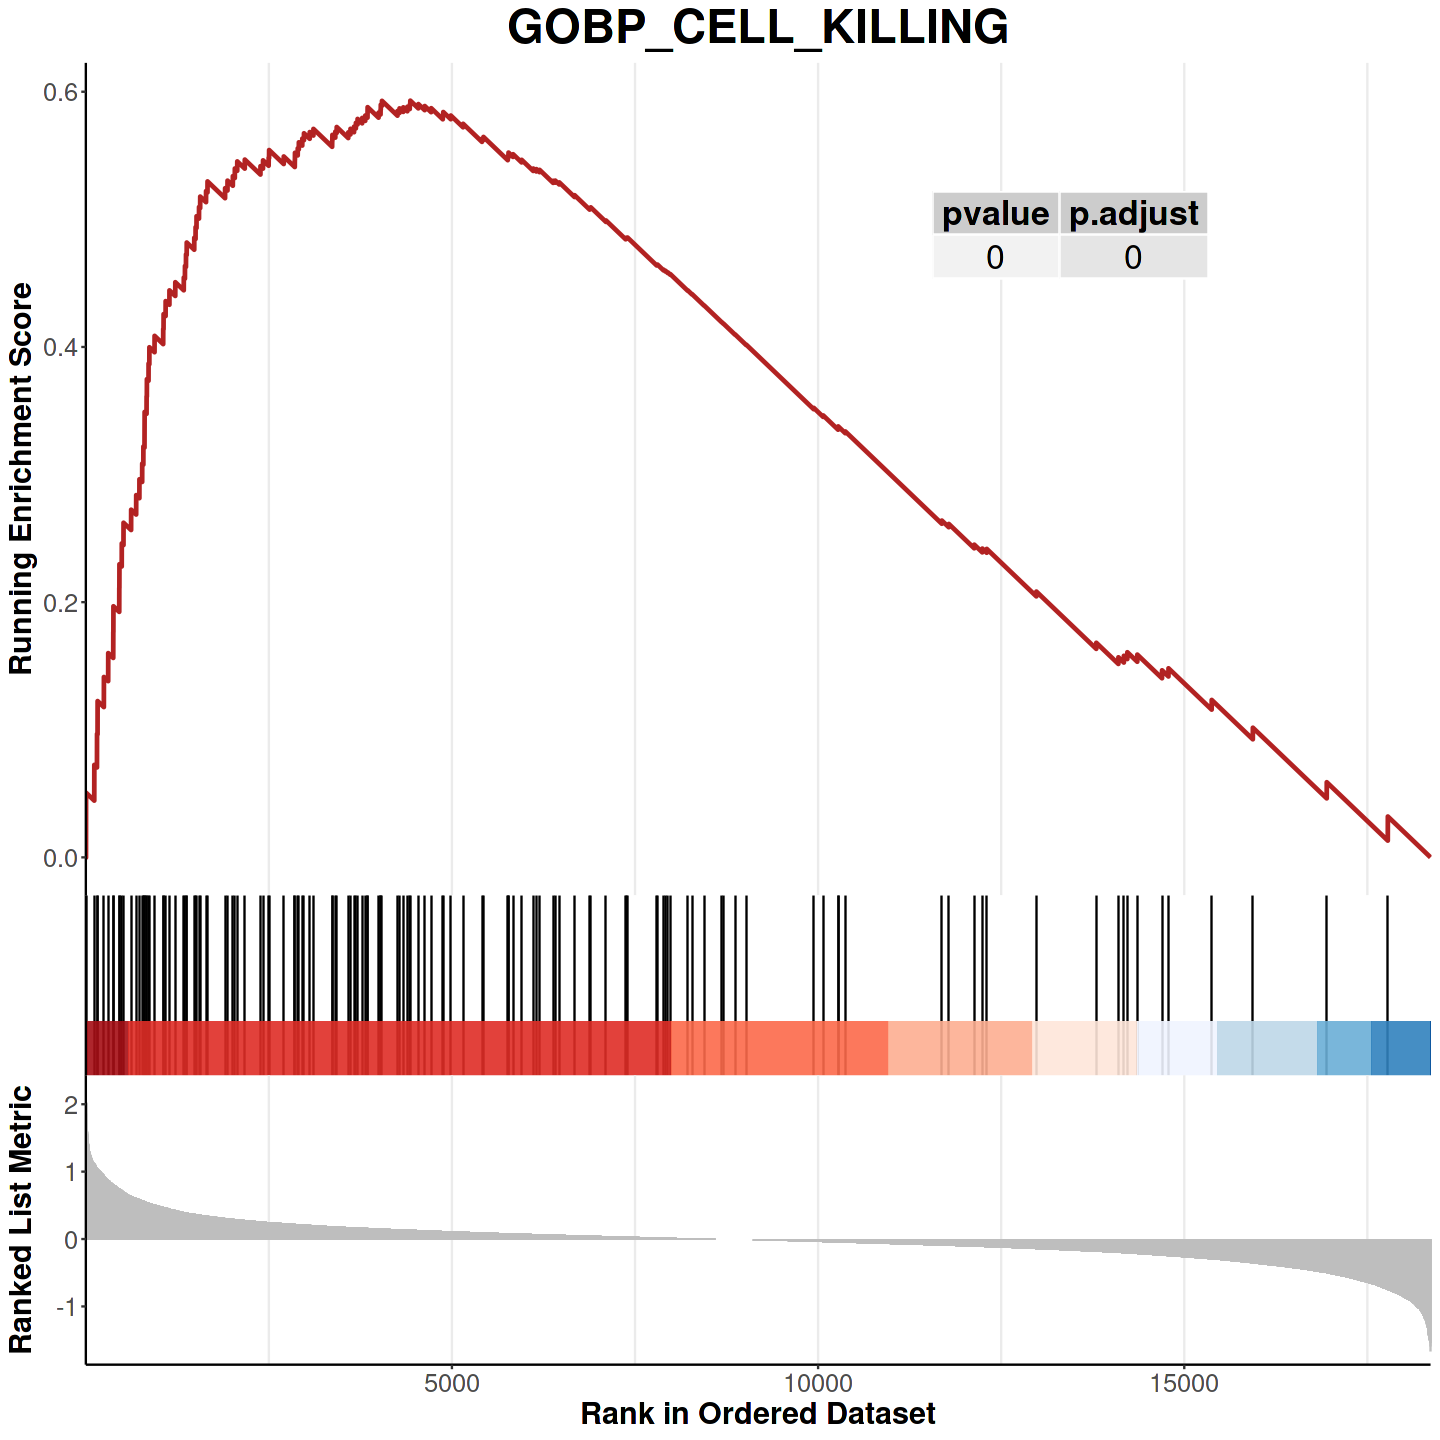

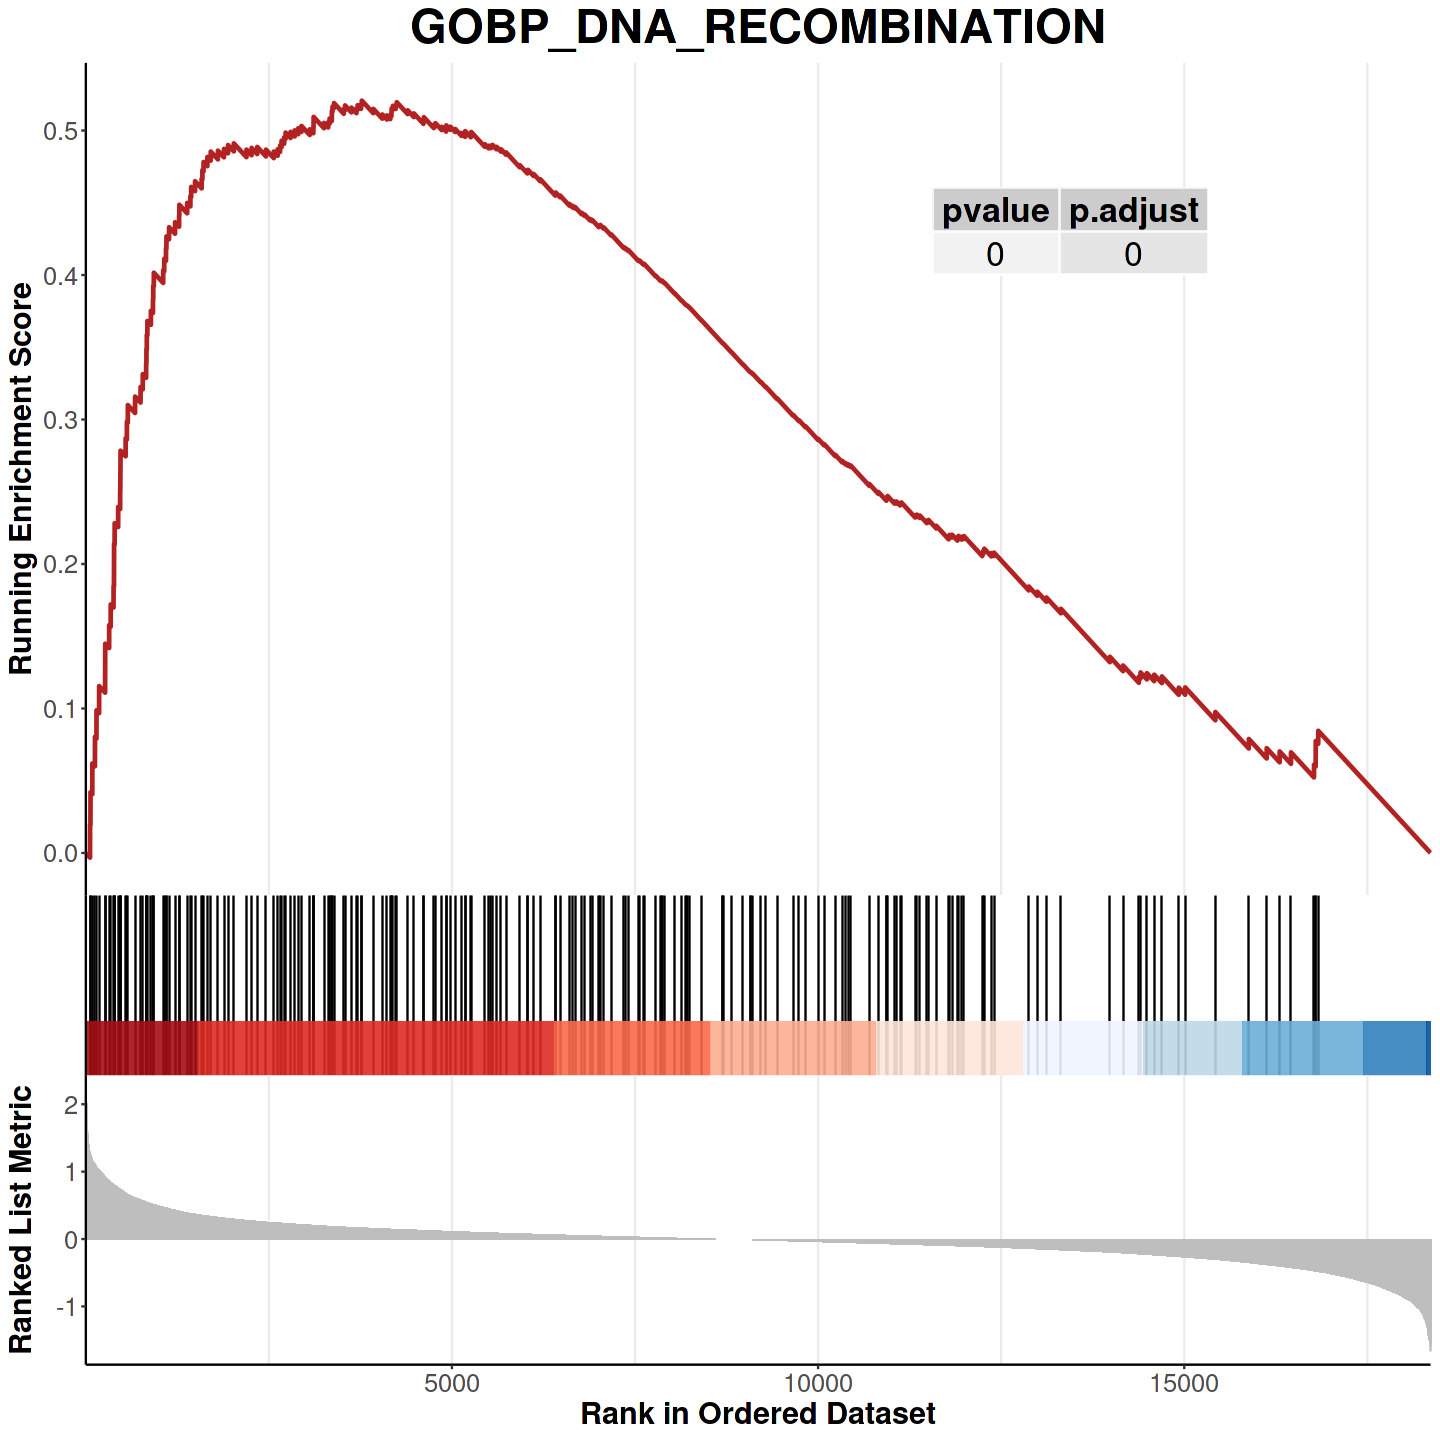

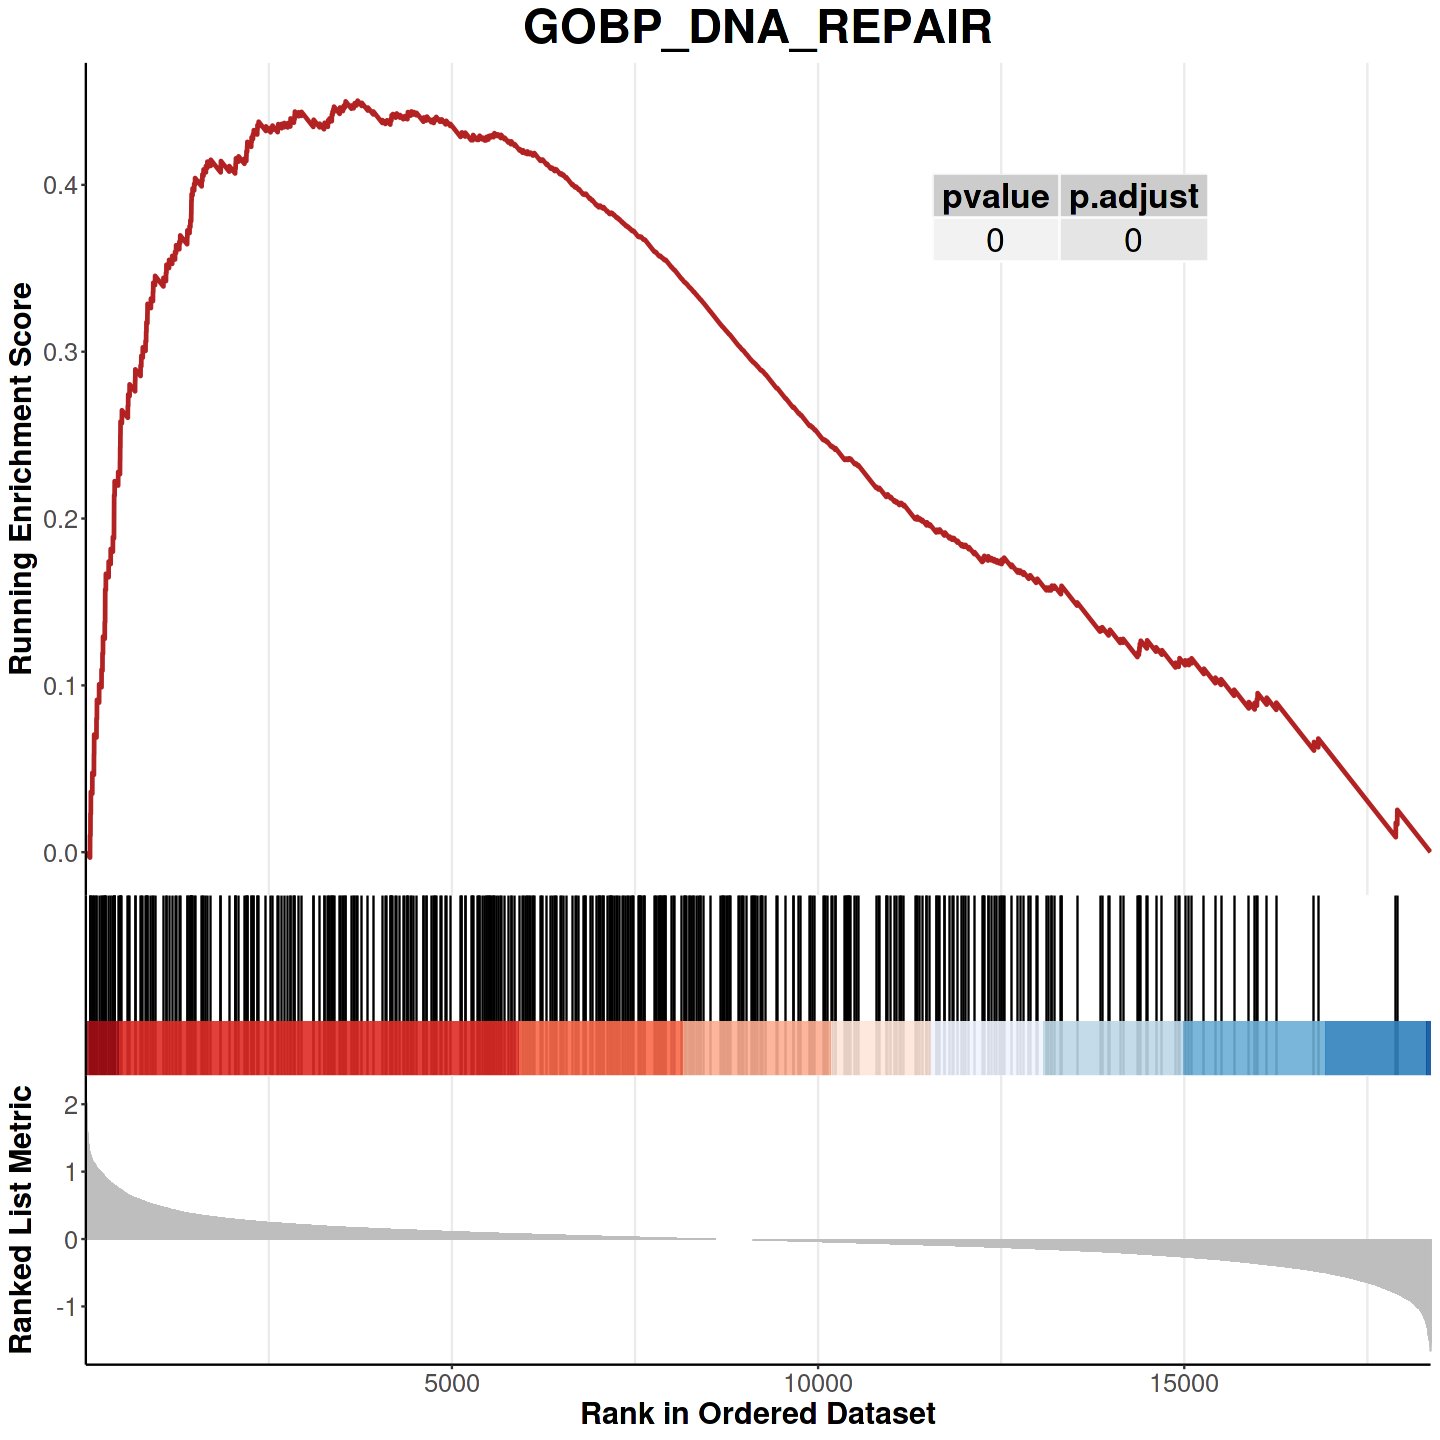

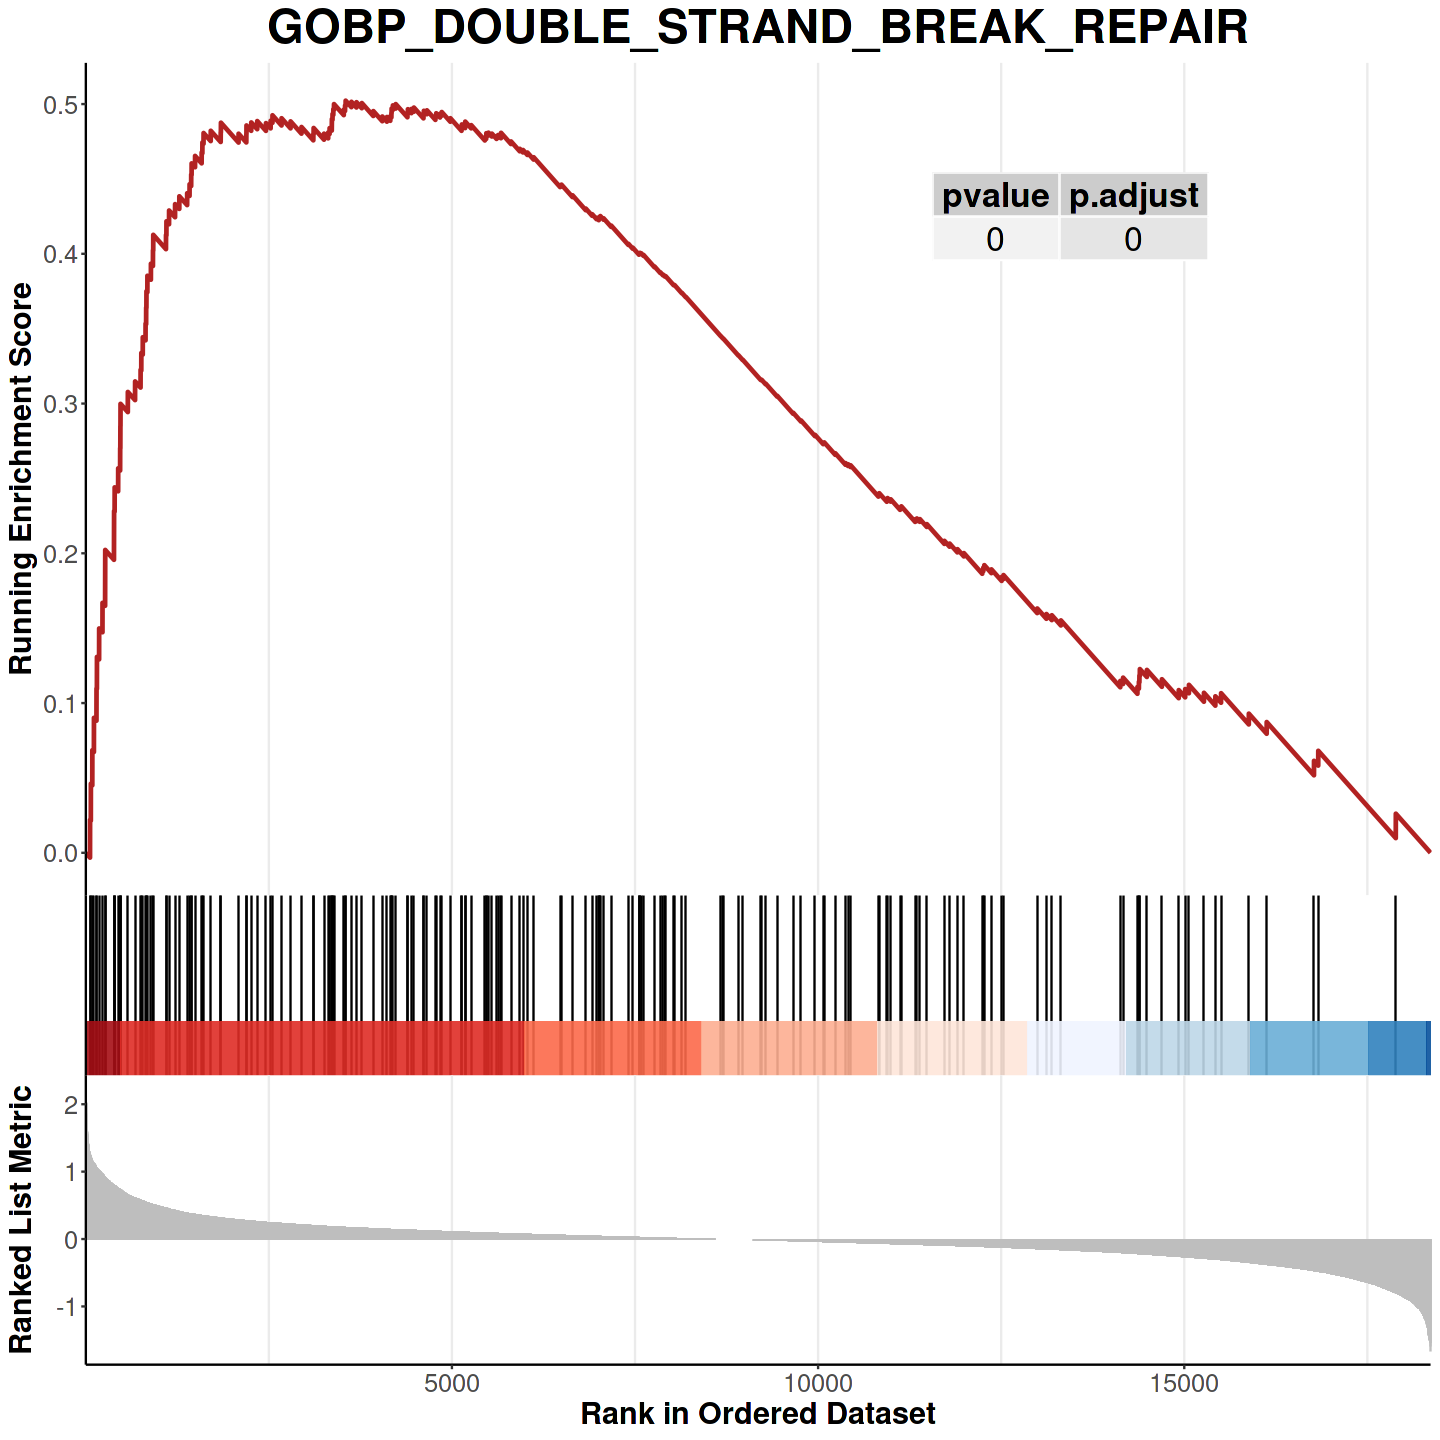

In [42]:
my_gseaplot2(res,"GOBP_ACTIVATION_OF_IMMUNE_RESPONSE",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_ACTIVATION_OF_IMMUNE_RESPONSE")
my_gseaplot2(res,"GOBP_ADAPTIVE_IMMUNE_RESPONSE",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_ADAPTIVE_IMMUNE_RESPONSE")
my_gseaplot2(res,"GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION")
my_gseaplot2(res,"GOBP_CELL_KILLING",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_CELL_KILLING")
my_gseaplot2(res,"GOBP_DNA_RECOMBINATION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DNA_RECOMBINATION")
my_gseaplot2(res,"GOBP_DNA_REPAIR",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DNA_REPAIR")
my_gseaplot2(res,"GOBP_DOUBLE_STRAND_BREAK_REPAIR",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DOUBLE_STRAND_BREAK_REPAIR")

In [43]:
# options(repr.plot.height = 10, repr.plot.width = 10)
pdf(file = "Artical_Figure2/Figure 3/GSEA.1.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_ACTIVATION_OF_IMMUNE_RESPONSE",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_ACTIVATION_OF_IMMUNE_RESPONSE")
dev.off()
pdf(file = "Artical_Figure2/Figure 3/GSEA.2.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION",
             title.size = 24,
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION")
dev.off()
pdf(file = "Artical_Figure2/Figure 3/GSEA.3.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_CELL_KILLING",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_CELL_KILLING")
dev.off()
pdf(file = "Artical_Figure2/Figure 3/GSEA.4.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_DNA_RECOMBINATION",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DNA_RECOMBINATION")
dev.off()
pdf(file = "Artical_Figure2/Figure 3/GSEA.5.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_DNA_REPAIR",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DNA_REPAIR")
dev.off()
pdf(file = "Artical_Figure2/Figure 3/GSEA.6.pdf",width = 10,height = 10)
my_gseaplot2(res,"GOBP_DOUBLE_STRAND_BREAK_REPAIR",
             self.Description = "",
          color="firebrick",
          pvalue_table = T,
          rel_heights = c(1, .2, 0.4),
          title = "GOBP_DOUBLE_STRAND_BREAK_REPAIR")
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

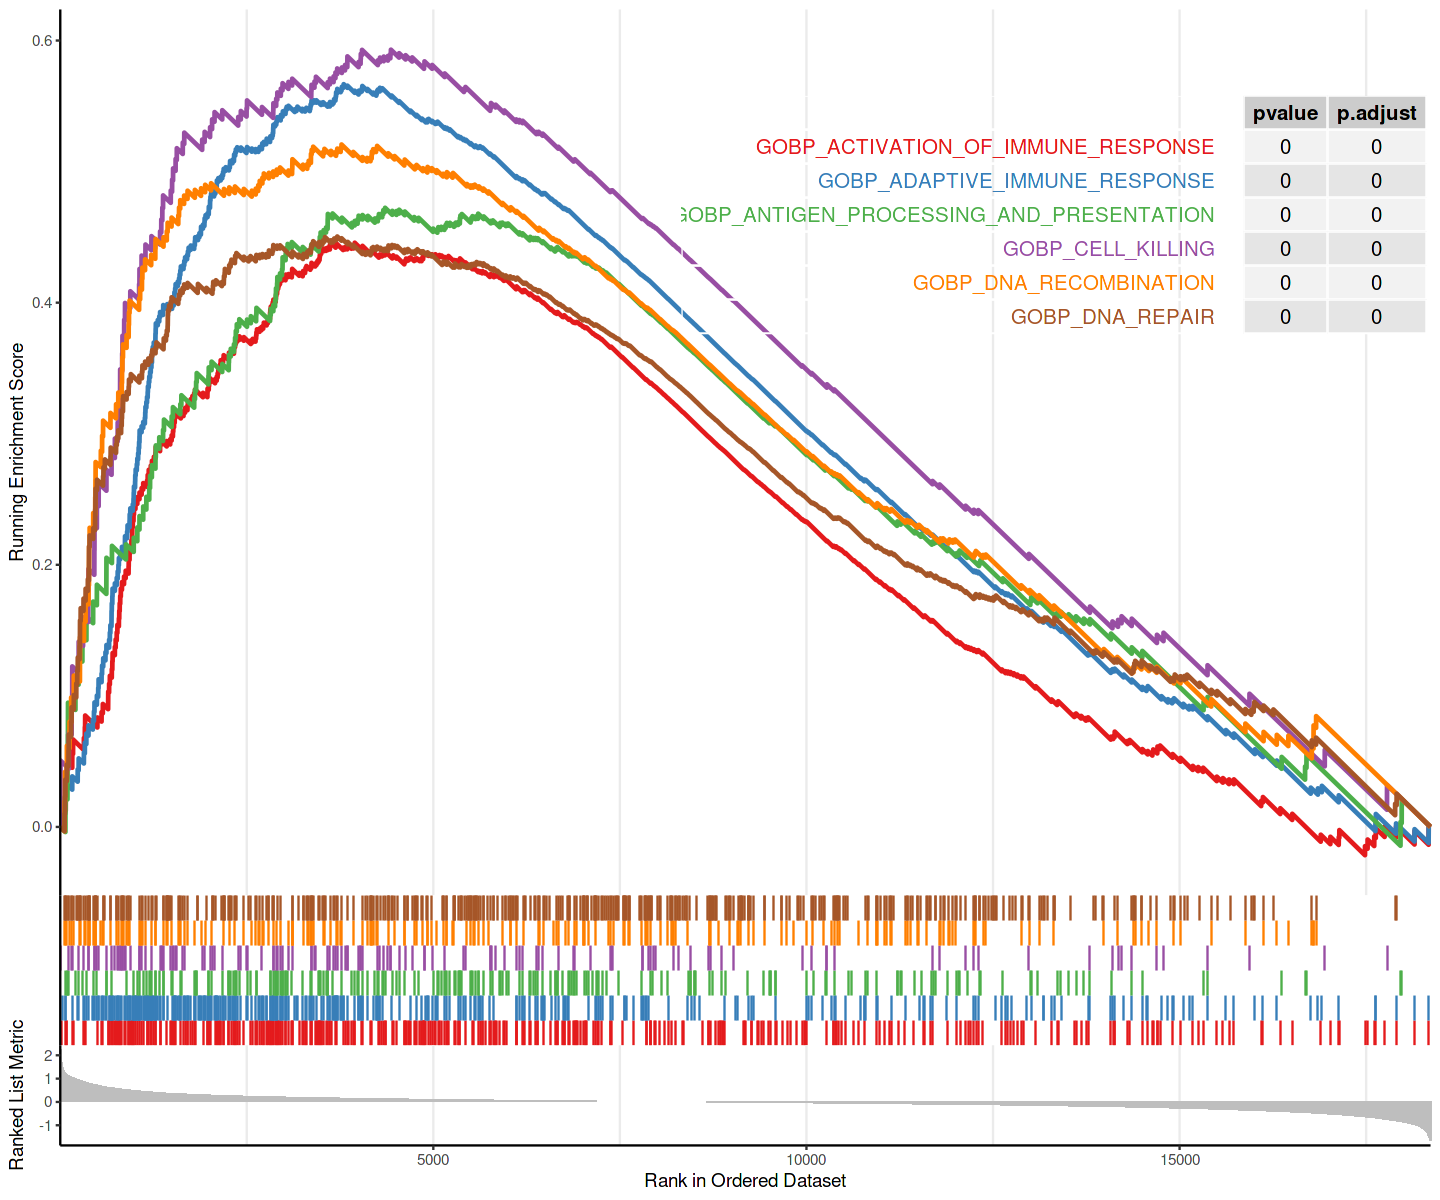

In [44]:
options(repr.plot.height = 10, repr.plot.width = 12)
p = gseaplot2(res,color = colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))(9)[c(1:5,7)],rel_heights = c(1.5, 0.25, 0.25),
          c("GOBP_ACTIVATION_OF_IMMUNE_RESPONSE",
                "GOBP_ADAPTIVE_IMMUNE_RESPONSE",
               "GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION",
               "GOBP_CELL_KILLING",
               "GOBP_DNA_RECOMBINATION",
               "GOBP_DNA_REPAIR"),pvalue_table = T)
p

In [45]:
pdf(file = "Artical_Figure2/Figure 3/GSEA.All.pdf",width = 12,height = 10)
p
dev.off()

png 
  2

### immune infiltration analysis

In [46]:
immune_infiltration_data = read.table(file = "/srv/shiny-server/SNVIO_V7/immune_infiltration.txt",header = T,check.names = F,stringsAsFactors = F,quote = "",sep = "\t")
celltype_geneset = list()
for( i in immune_infiltration_data$`Cell type`){
  celltype_geneset[[i]] = immune_infiltration_data$Metagene[ immune_infiltration_data$`Cell type` == i]
}

new_geneset = c(celltype_geneset)

# m = apply(All_RNA,1,function(x){sum(x>0)>ncol(All_RNA)*0.1})
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]
ssgsea_score = gsva(as.matrix(tmp_data), new_geneset, method = "ssgsea", ssgsea.norm = TRUE, verbose = TRUE,parallel.sz=12)
ssGSEA_result = ssgsea_score

Setting parallel calculations through a MulticoreParam back-end
with workers=12 and tasks=100.
Estimating ssGSEA scores for 28 gene sets.
  |======================================================================| 100%



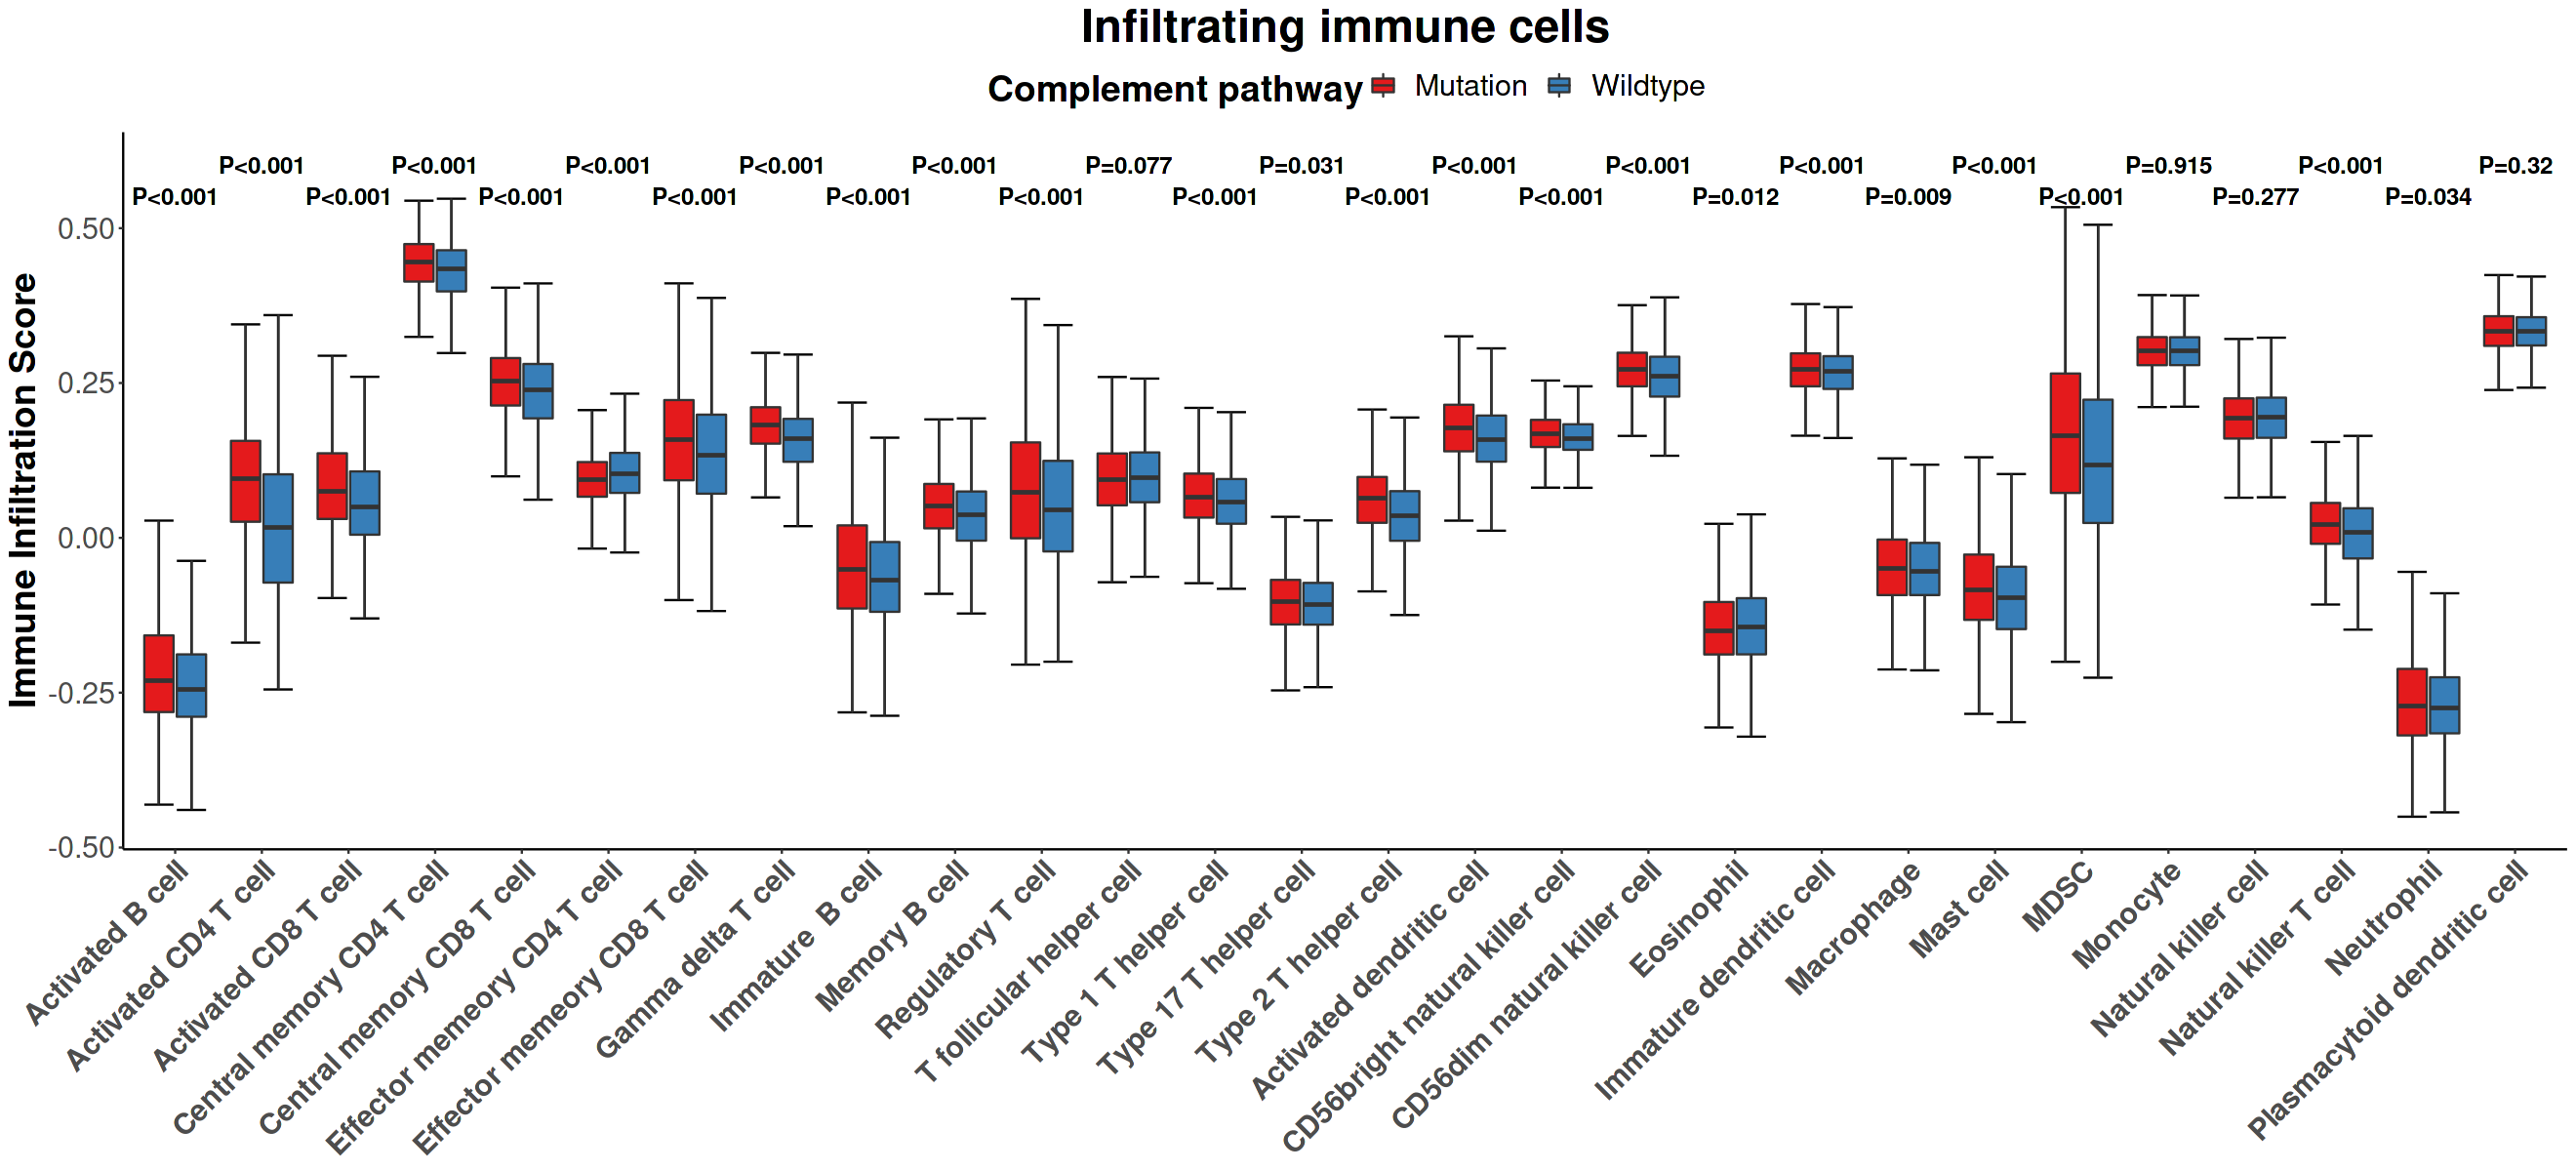

In [47]:
mut_values = ssgsea_score[names(celltype_geneset),colnames(Complement_Mut_matrix)]
wt_values = ssgsea_score[names(celltype_geneset),colnames(Complement_Wt_matrix)]

mut_values = melt(mut_values)
mut_values = mut_values[,-2]
colnames(mut_values)[1] = "immune_infiltration"
mut_values$groups = "Mutation"
  
wt_values = melt(wt_values)
wt_values = wt_values[,-2]
colnames(wt_values)[1] = "immune_infiltration"
wt_values$groups = "Wildtype"
  
tmp_ssgsea = rbind(mut_values,wt_values)

lim1 = vector()
lim2 = vector()
md = vector()
for(i in unique(tmp_ssgsea$immune_infiltration)){
    lim1 = c(lim1,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(1,5)])
    lim2 = c(lim2,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(1,5)])

    md1 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(3)]
    md2 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(3)]
    md = c(md,mean(md1,md2))
}

ylim_all = c(lim1,lim2)
ylim1 = c(min(ylim_all),max(ylim_all))
names(md) = unique(tmp_ssgsea$immune_infiltration)

# tmp_ssgsea$immune_infiltration = factor(tmp_ssgsea$immune_infiltration,levels = names(sort(md,decreasing = T)))


p = ggplot(data = tmp_ssgsea,aes(x = immune_infiltration,y=value,fill=groups))+
    ggtitle("Infiltrating immune cells")+
    stat_boxplot(geom = "errorbar")+
    geom_boxplot(alpha = 1,outlier.alpha = 0)+
    coord_cartesian(ylim = c(ylim1[1],ylim1[2]*1.1))+
    theme_classic()+
    labs(fill = "Complement pathway")+
    ylab("Immune Infiltration Score")+
    scale_fill_manual(values = c("#E41A1C", "#377EB8"))+
    theme(axis.text.x = element_text(hjust = 1,angle = 45,size = 18,face = "bold"),
          plot.title = element_text(hjust = 0.5,size = 28,face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 22,face = "bold"),
          axis.text.y = element_text(size = 18),
          legend.text = element_text(size = 18),
          legend.title = element_text(size = 22,face = "bold"),
          legend.position = "top")
  n = 1
  for(i in unique(tmp_ssgsea$immune_infiltration)){
    
    res = wilcox.test(value~groups,data = tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,])
    max_val = max(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,"value"])
    p = p+
      annotate("text",x = n,y = ylim1[2]*1.1-(n%%2)/20,label = ifelse(res$p.value< 0.001,"P<0.001",paste("P=",round(res$p.value,digits = 3),sep = "")),size = 5,fontface="bold")
    n = n + 1
  }
options(repr.plot.height = 10, repr.plot.width = 22)
print(p)

In [49]:
pdf("Artical_Figure2/Figure 3/Immune_Infiltration_ssGSEA.pdf",width = 23,height = 10)
p
dev.off()

png 
  2

### Cibersort

In [50]:
raw_RNA = 2^(All_RNA)-1

In [51]:
library('CIBERSORT')
library("preprocessCore")

sig_matrix <- system.file("extdata", "LM22.txt", package = "CIBERSORT")
results <- cibersort(sig_matrix, as.matrix(raw_RNA),perm = 1000,QN = T)
saveRDS(object = results,file = "TCGA_PanCancer_cibersort.rds")

In [52]:
results = readRDS("TCGA_PanCancer_cibersort.rds")

In [53]:
cibersort_result = as.data.frame(t(results[,1:(ncol(results)-3)]))

In [54]:
colnames(cibersort_result) = colnames(raw_RNA)

In [56]:
rn = rownames(anno)

Using genename as id variables

Using genename as id variables



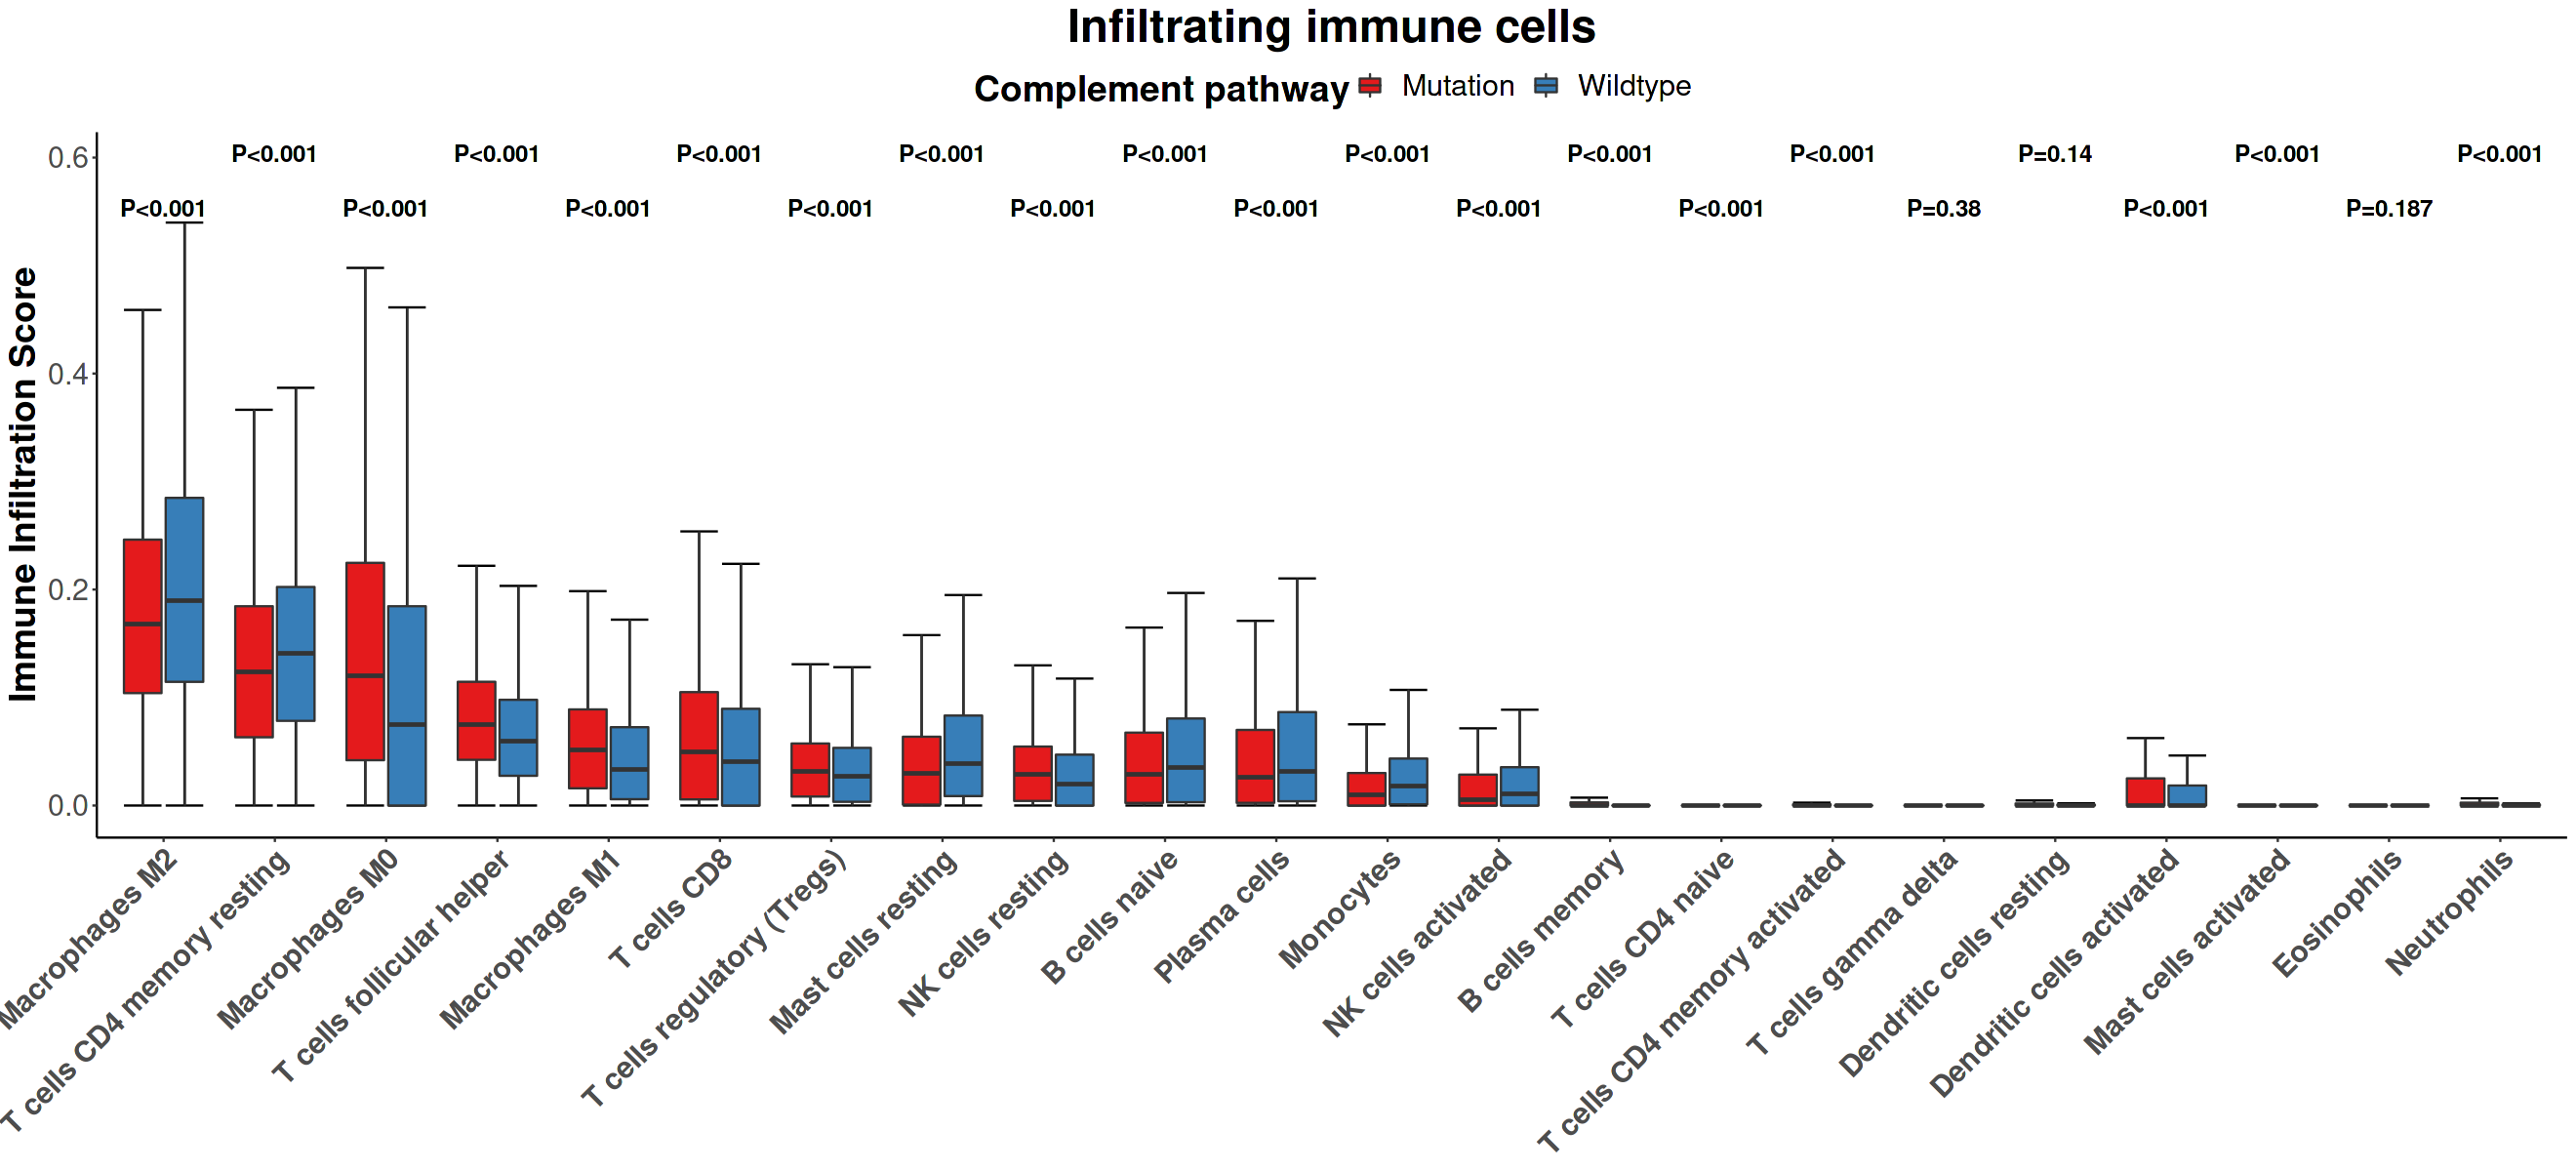

In [57]:
mut_values = cibersort_result[,intersect(rn,colnames(Complement_Mut_matrix))]
mut_values$genename = rownames(mut_values)
wt_values = cibersort_result[,intersect(rn,colnames(Complement_Wt_matrix))]
wt_values$genename = rownames(wt_values)

mut_values = melt(mut_values)
mut_values = mut_values[,-2]
colnames(mut_values)[1] = "immune_infiltration"
mut_values$groups = "Mutation"
  
wt_values = melt(wt_values)
wt_values = wt_values[,-2]
colnames(wt_values)[1] = "immune_infiltration"
wt_values$groups = "Wildtype"
  
tmp_ssgsea = rbind(mut_values,wt_values)


lim1 = vector()
lim2 = vector()
md = vector()
for(i in unique(tmp_ssgsea$immune_infiltration)){
    lim1 = c(lim1,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(1,5)])
    lim2 = c(lim2,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(1,5)])

    md1 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(3)]
    md2 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(3)]
    md = c(md,mean(md1,md2))
}

ylim_all = c(lim1,lim2)
ylim1 = c(min(ylim_all),max(ylim_all))
names(md) = unique(tmp_ssgsea$immune_infiltration)

tmp_ssgsea$immune_infiltration = factor(tmp_ssgsea$immune_infiltration,levels = names(sort(md,decreasing = T)))
p = ggplot(data = tmp_ssgsea,aes(x = immune_infiltration,y=value,fill=groups))+
    ggtitle("Infiltrating immune cells")+
    stat_boxplot(geom = "errorbar")+
    geom_boxplot(alpha = 1,outlier.colour = NA)+
    theme_classic()+
    coord_cartesian(ylim = c(ylim1[1],ylim1[2]*1.1))+
    labs(fill = "Complement pathway")+
    ylab("Immune Infiltration Score")+
    scale_fill_manual(values = c("#E41A1C", "#377EB8"))+
    theme(axis.text.x = element_text(hjust = 1,angle = 45,size = 18,face = "bold"),
          plot.title = element_text(hjust = 0.5,size = 28,face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 22,face = "bold"),
          axis.text.y = element_text(size = 18),
          legend.text = element_text(size = 18),
          legend.title = element_text(size = 22,face = "bold"),
          legend.position = "top")
  n = 1
  for(i in levels(tmp_ssgsea$immune_infiltration)){
    
    res = wilcox.test(value~groups,data = tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,])
    max_val = max(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,"value"])
    p = p+
      annotate("text",x = n,y = ylim1[2]*1.1-(n%%2)/20+0.01,label = ifelse(res$p.value< 0.001,"P<0.001",paste("P=",round(res$p.value,digits = 3),sep = "")),size = 5,fontface="bold")
    n = n + 1
  }
options(repr.plot.height = 10, repr.plot.width = 22)
print(p)

In [71]:
pdf("Artical_Figure2/Figure 3/Immune_Infiltration_Cibersort.pdf",width = 23,height = 10)
p
dev.off()

png 
  2

In [59]:
tmp_ssgsea2 = tmp_ssgsea[as.character(tmp_ssgsea$immune_infiltration) %in% levels(tmp_ssgsea$immune_infiltration)[c(1:12,19)],]

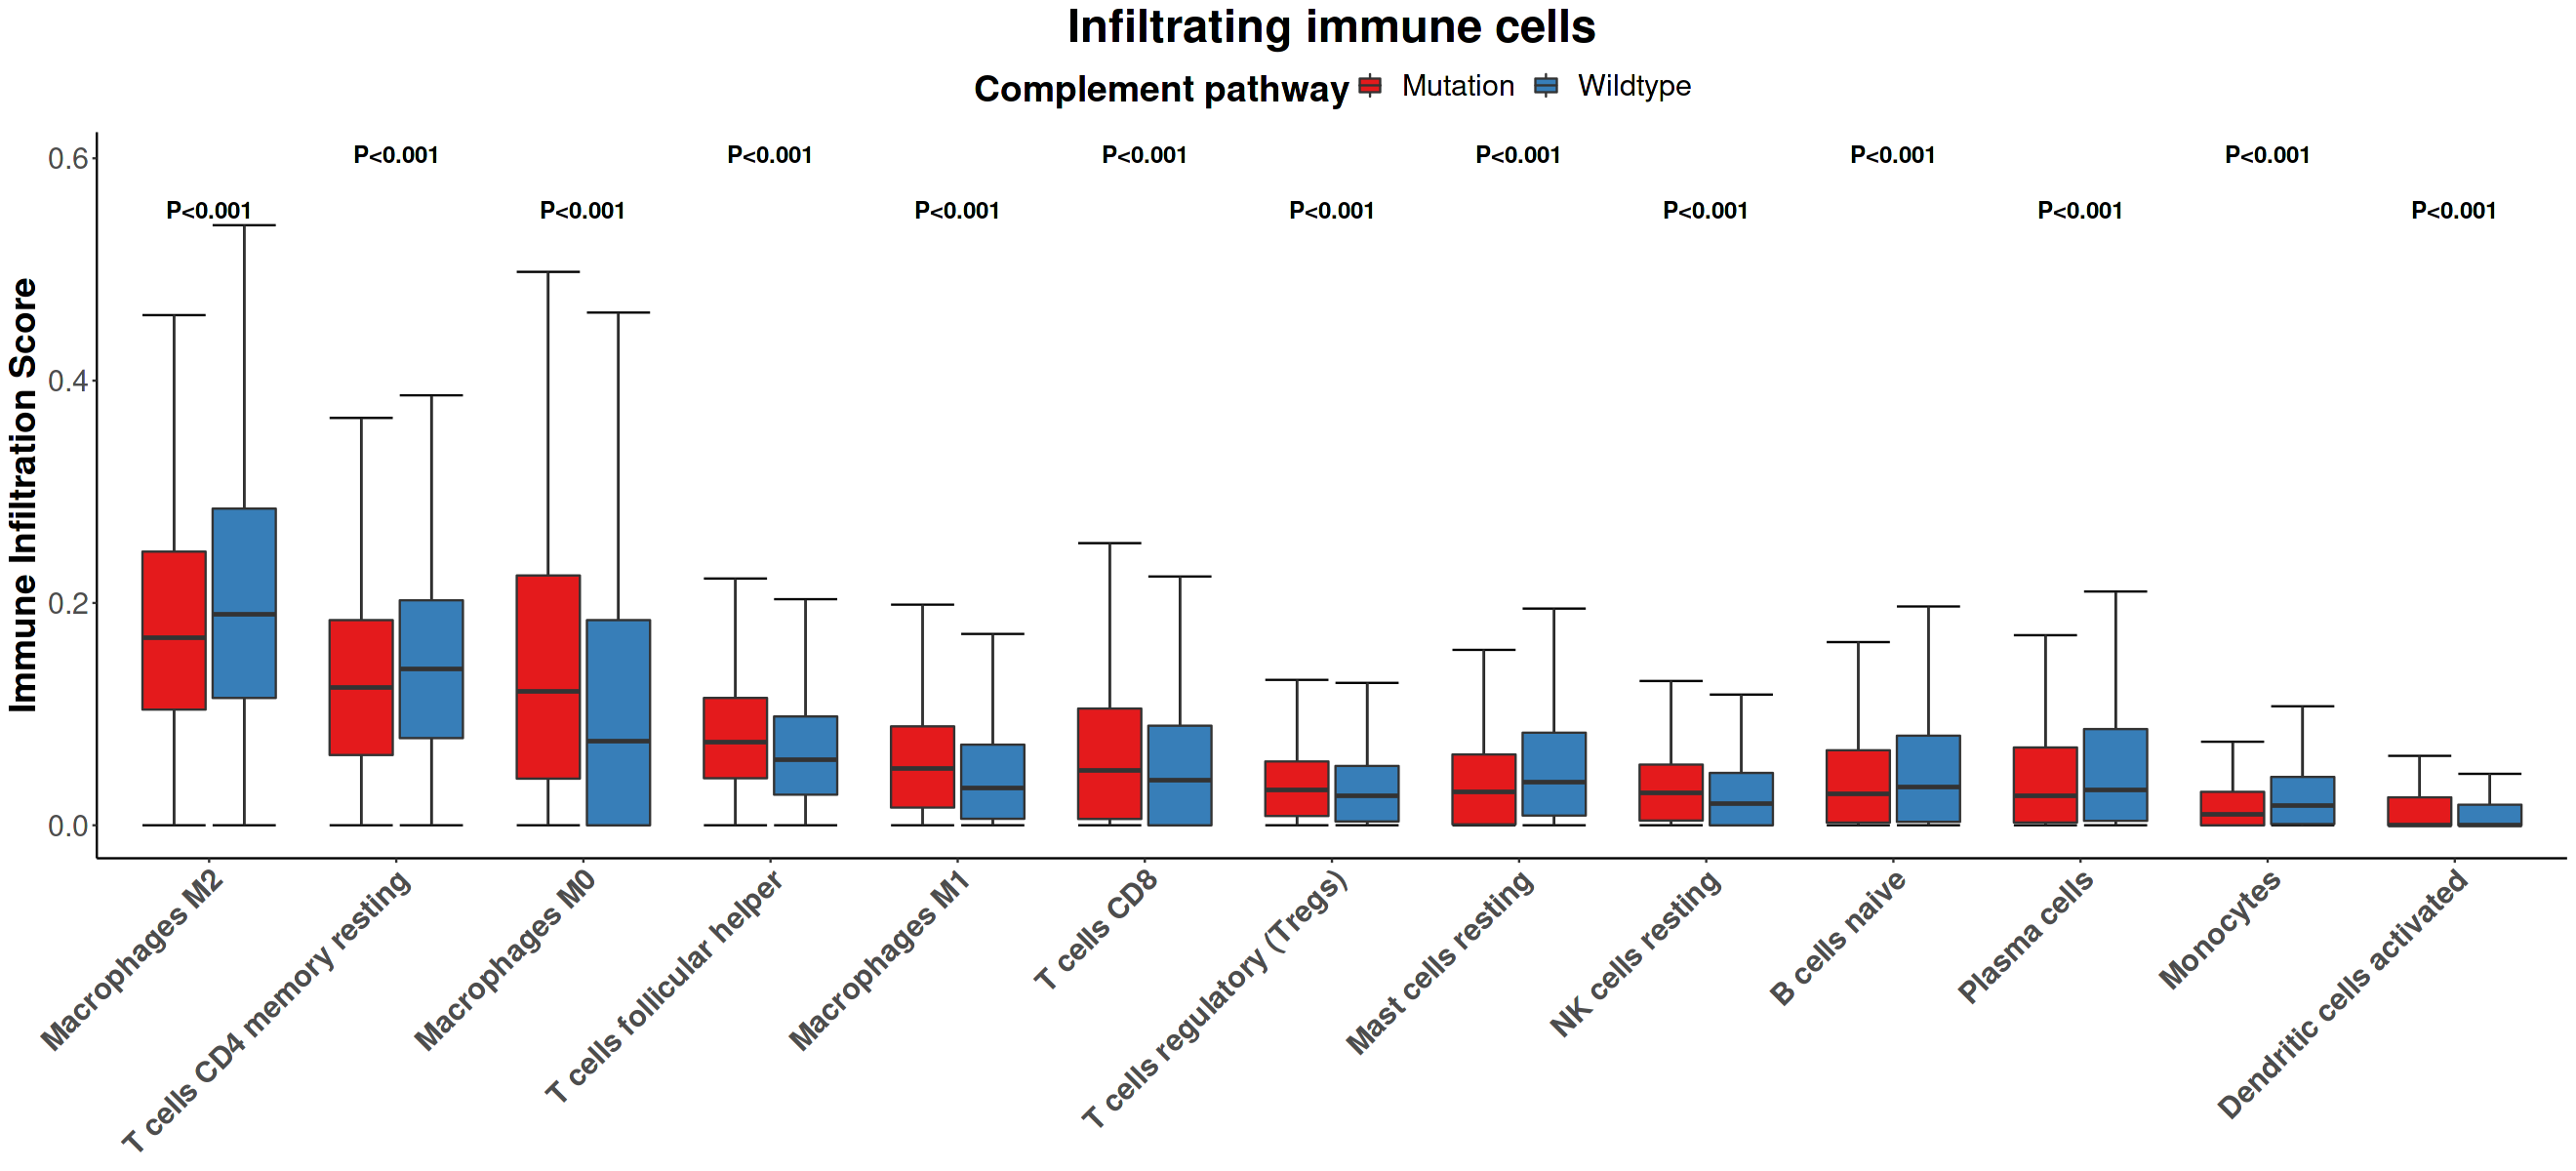

In [60]:
p = ggplot(data = tmp_ssgsea2,aes(x = immune_infiltration,y=value,fill=groups))+
    ggtitle("Infiltrating immune cells")+
    stat_boxplot(geom = "errorbar")+
    geom_boxplot(alpha = 1,outlier.colour = NA)+
    theme_classic()+
    coord_cartesian(ylim = c(ylim1[1],ylim1[2]*1.1))+
    labs(fill = "Complement pathway")+
    ylab("Immune Infiltration Score")+
    scale_fill_manual(values = c("#E41A1C", "#377EB8"))+
    theme(axis.text.x = element_text(hjust = 1,angle = 45,size = 18,face = "bold"),
          plot.title = element_text(hjust = 0.5,size = 28,face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 22,face = "bold"),
          axis.text.y = element_text(size = 18),
          legend.text = element_text(size = 18),
          legend.title = element_text(size = 22,face = "bold"),
          legend.position = "top")
  n = 1
  for(i in unique(tmp_ssgsea2$immune_infiltration)){
    
    res = wilcox.test(value~groups,data = tmp_ssgsea2[tmp_ssgsea2$immune_infiltration == i,])
    max_val = max(tmp_ssgsea2[tmp_ssgsea2$immune_infiltration == i,"value"])
    p = p+
      annotate("text",x = n,y = ylim1[2]*1.1-(n%%2)/20+0.01,label = ifelse(res$p.value< 0.001,"P<0.001",paste("P=",round(res$p.value,digits = 3),sep = "")),size = 5,fontface="bold")
    n = n + 1
  }
options(repr.plot.height = 10, repr.plot.width = 22)
print(p)

In [61]:
pdf("Artical_Figure2/Figure 3/Immune_Infiltration_Cibersort.pdf",width = 23,height = 10)
p
dev.off()

png 
  2

### immune signature analysis

##### ssGSEA

In [62]:
immune = list(
#   "6-gene IFN signature" = c("IDO1", "CXCL9", "CXCL10", "HLA-DRA", "STAT1", "IFNG"),
  "18-gene IFN signature" = c("CD3D", "IDO1", "CIITA", "CD3E", "CCL5", "GZMK", "CD2", "HLA-DRA", "CXCL13", "IL2RG", "NKG7", "HLA-E", "CXCR6", "LAG3", "TAGAP", "CXCL10", "STAT1", "GZMB"),
  "Gene expression profile" = c("CXCR6", "TIGIT", "CD27", "CD274", "PDCD1LG2", "LAG3", "NKG7", "PSMB10", "CMKLR1", "CD8A", "IDO1", "CCL5", "CXCL9", "HLA-DQA1", "CD276", "HLA-DRB1", "STAT1", "HLA-E"),
  "Cytolytic activity" = c("GZMA", "PRF1"),
  "13 T-cell signature" = c("CD8A", "CCL2", "CCL3", "CCL4", "CXCL9", "CXCL10", "ICOS", "GZMK", "IRF1","HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB"),
  "Effective T cell score" = c("CD8A", "EOMES", "PRF1", "IFNG", "CD274"),
  "Immune checkpoint expression" = c("CD274", "CTLA4", "HAVCR2", "LAG3", "PDCD1", "PDCD1LG2", "TIGIT"),
  "TLS" = c("CCL21", "CCL19", "CXCL13", "CXCL11", "CCL8", "CXCL10", "CXCL9", "CCL2", "CCL3", "CCL18", "CCL5")
)

In [63]:
library(openxlsx)
MFP_signature = read.xlsx("MFP_signature.xlsx",sheet = 3,startRow = 2)
MFP_geneset = list()
for( i in MFP_signature$Gene.signature){
  MFP_geneset[[i]] = MFP_signature$Gene[ MFP_signature$Gene.signature == i]
}

CAF_signature = read.xlsx("CCR_CAF_signature.xlsx",sheet = 3,startRow = 2)
CAF_geneset = list()
for( i in colnames(CAF_signature)){
  CAF_geneset[[i]] = CAF_signature[[i]][!is.na(CAF_signature[[i]])]
}

In [64]:
immune = c(immune,MFP_geneset[c("Angiogenesis","Endothelium","Antitumor cytokines","Effector cell traffic")],
                CAF_geneset[c("pan-myCAF","pan-iCAF")])

In [86]:
names(immune)

[1] "18-gene IFN signature"        "Gene expression profile"     
 [3] "Cytolytic activity"           "13 T-cell signature"         
 [5] "Effective T cell score"       "Immune checkpoint expression"
 [7] "TLS"                          "Angiogenesis"                
 [9] "Endothelium"                  "Antitumor cytokines"         
[11] "Effector cell traffic"        "pan-myCAF"                   
[13] "pan-iCAF"

In [90]:
for (i in names(immune)) {
  write.table(paste(c(i,immune[[i]]),collapse = ","), "./Artical_Figure2/Figure 3/TME_Signature.csv",col.names = F, append = T,row.names = F,quote = F)
}

In [65]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]
ssgsea_score = gsva(as.matrix(tmp_data), immune, method = "ssgsea", ssgsea.norm = TRUE, verbose = TRUE,parallel.sz=12)
signature_score = ssgsea_score

Setting parallel calculations through a MulticoreParam back-end
with workers=12 and tasks=100.
Estimating ssGSEA scores for 13 gene sets.
  |======================================================================| 100%



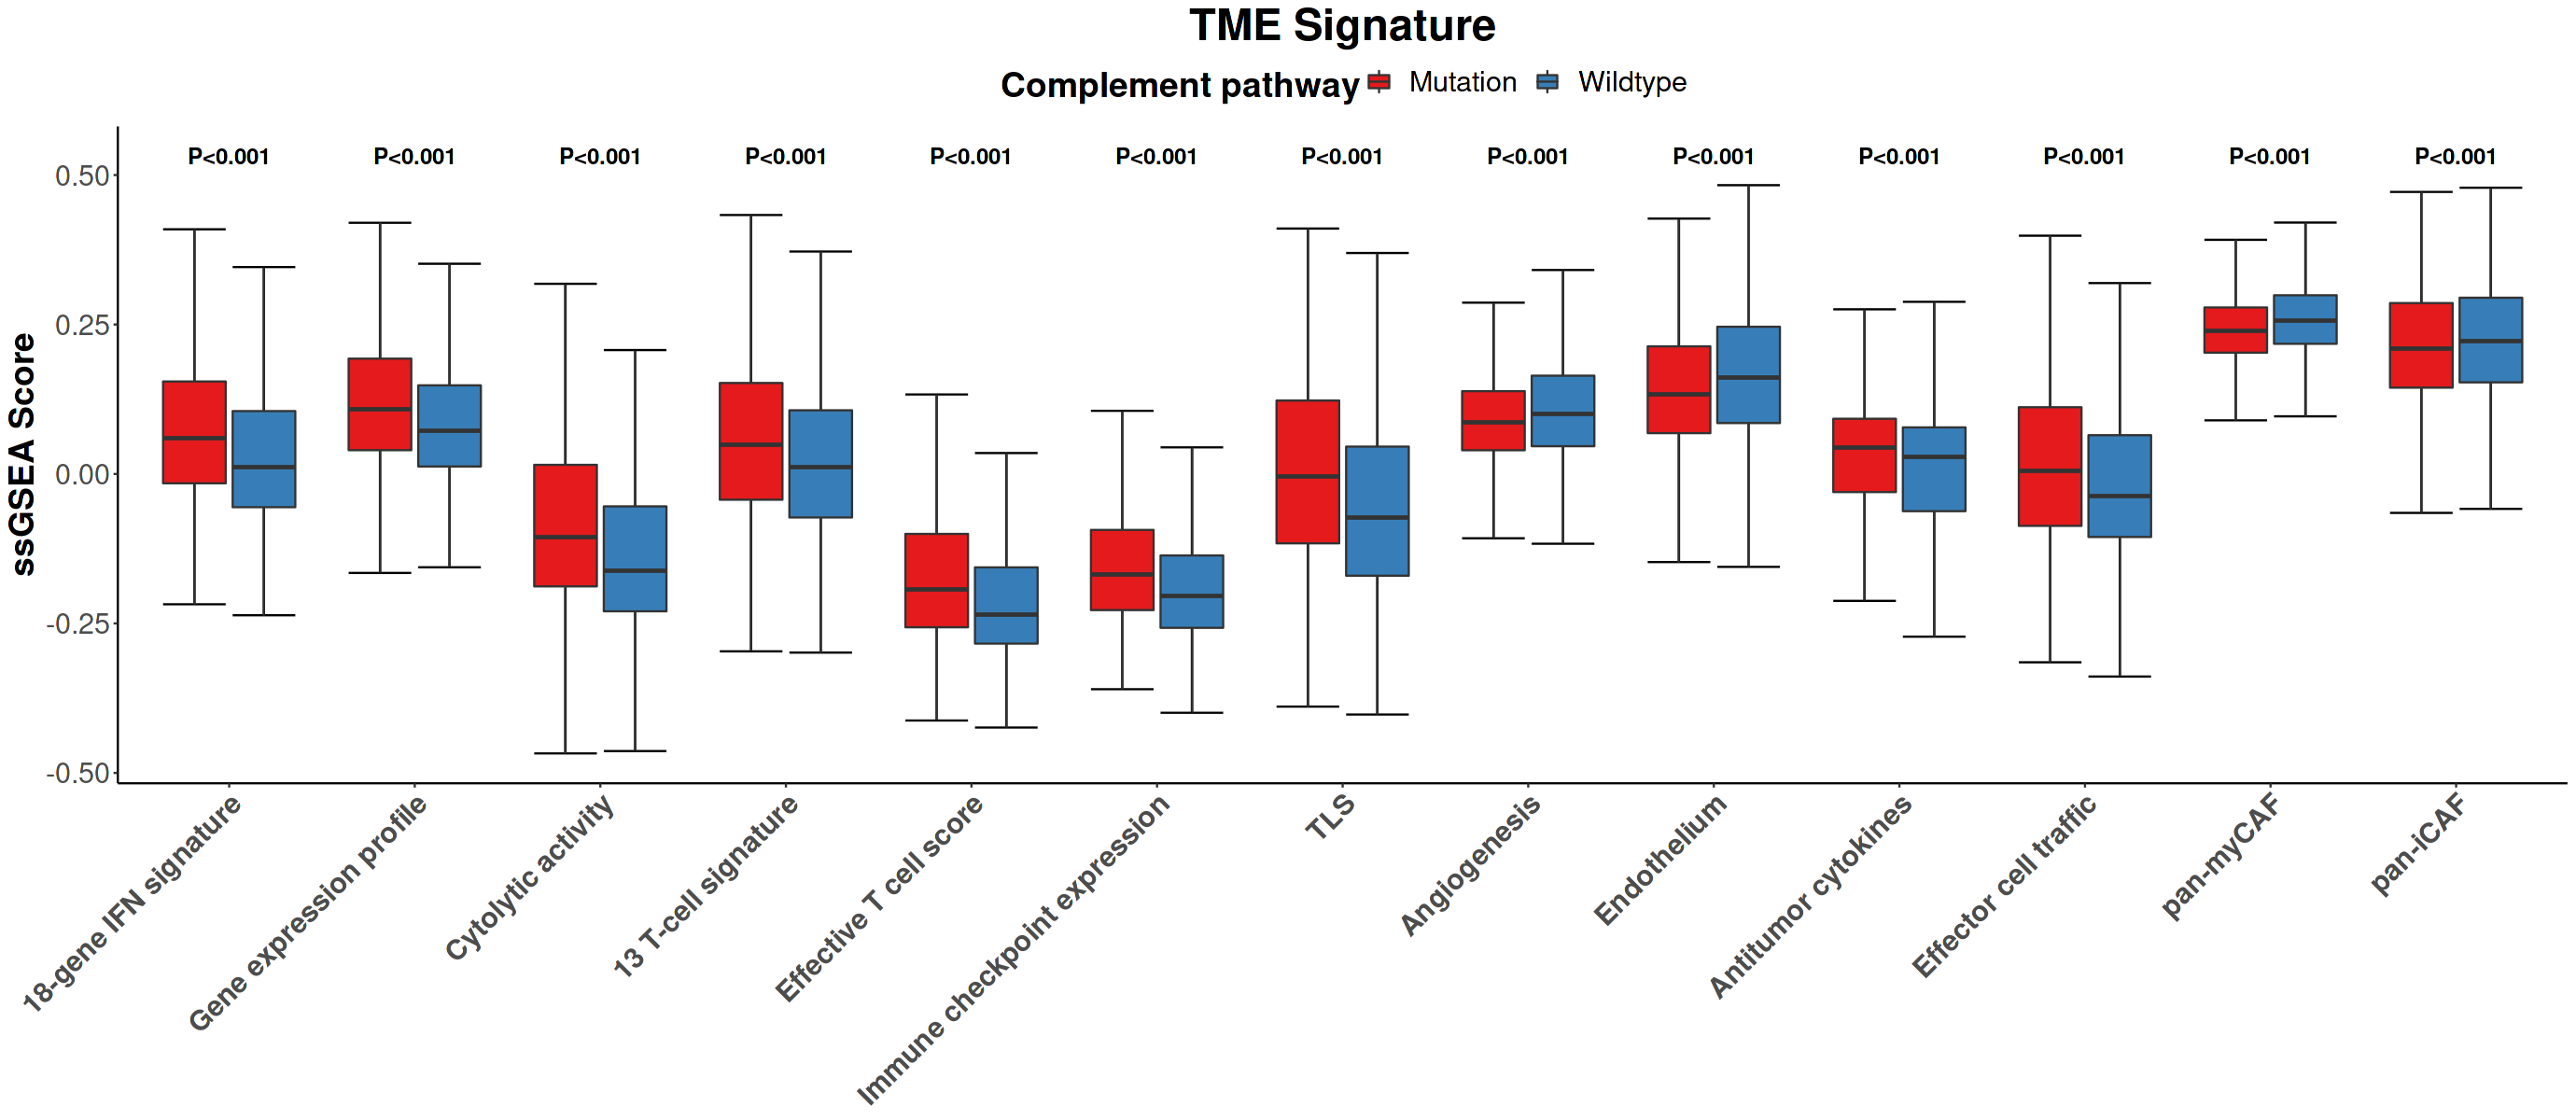

In [66]:
mut_values = ssgsea_score[names(immune),colnames(Complement_Mut_matrix)]
wt_values = ssgsea_score[names(immune),colnames(Complement_Wt_matrix)]

mut_values = melt(mut_values)
mut_values = mut_values[,-2]
colnames(mut_values)[1] = "immune_infiltration"
mut_values$groups = "Mutation"
  
wt_values = melt(wt_values)
wt_values = wt_values[,-2]
colnames(wt_values)[1] = "immune_infiltration"
wt_values$groups = "Wildtype"
  
tmp_ssgsea = rbind(mut_values,wt_values)

lim1 = vector()
lim2 = vector()
md = vector()
for(i in unique(tmp_ssgsea$immune_infiltration)){
    lim1 = c(lim1,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(1,5)])
    lim2 = c(lim2,boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(1,5)])

    md1 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Mutation","value"])$stats[c(3)]
    md2 = boxplot.stats(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i & tmp_ssgsea$groups == "Wildtype","value"])$stats[c(3)]
    md = c(md,mean(md1,md2))
}

ylim_all = c(lim1,lim2)
ylim1 = c(min(ylim_all),max(ylim_all))
names(md) = unique(tmp_ssgsea$immune_infiltration)

# tmp_ssgsea$immune_infiltration = factor(tmp_ssgsea$immune_infiltration,levels = names(sort(md,decreasing = T)))


p = ggplot(data = tmp_ssgsea,aes(x = immune_infiltration,y=value,fill=groups))+
    ggtitle("TME Signature")+
    stat_boxplot(geom = "errorbar")+
    geom_boxplot(alpha = 1,outlier.alpha = 0)+
    coord_cartesian(ylim = c(ylim1[1],ylim1[2]*1.1))+
    theme_classic()+
    labs(fill = "Complement pathway")+
    ylab("ssGSEA Score")+
    scale_fill_manual(values = c("#E41A1C", "#377EB8"))+
    theme(axis.text.x = element_text(hjust = 1,angle = 45,size = 18,face = "bold"),
          plot.title = element_text(hjust = 0.5,size = 28,face = "bold"),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 22,face = "bold"),
          axis.text.y = element_text(size = 18),
          legend.text = element_text(size = 18),
          legend.title = element_text(size = 22,face = "bold"),
          legend.position = "top")
  n = 1
  for(i in unique(tmp_ssgsea$immune_infiltration)){
    
    res = wilcox.test(value~groups,data = tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,])
    max_val = max(tmp_ssgsea[tmp_ssgsea$immune_infiltration == i,"value"])
    p = p+
      annotate("text",x = n,y = ylim1[2]*1.1,label = ifelse(res$p.value< 0.001,"P<0.001",paste("P=",round(res$p.value,digits = 3),sep = "")),size = 5,fontface="bold")
    n = n + 1
  }
options(repr.plot.height = 10, repr.plot.width = 23)
print(p)

In [67]:
pdf("Artical_Figure2/Figure 3/Immune_Signature_ssGSEA.pdf",width = 23,height = 10)
p
dev.off()

png 
  2

### Part of cancer types

In [71]:

TCGA_cohort_cal_pm = function(TCGA,cancer_type,pathway,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[pathway]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[pathway]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[pathway]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

### immune infiltration -- 28

In [72]:
res = vector()
immune_module = "immune_infiltration"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$mut)
  wt = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$wt)
  tmp = cbind(rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,mut]),rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,wt]))
  colnames(tmp) = paste(cancer_type,c("Mutation","Wildtype"),sep = "_")
  # colnames(tmp) = c("Mutation","Wildtype")
  res = cbind(res,tmp)
  
}

pname = c("Activated CD4 T cell",
          "Activated CD8 T cell",
          "Effector memeory CD8 T cell",
          "Activated dendritic cell",
          "Natural killer T cell")

for(i in pname){
  tmp_mat = reshape2::melt(res[i,])
  tmp_mat$mut_wt = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,2]
  tmp_mat$Cancer_type = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,1]
  tmp_mat$mut_wt = factor(tmp_mat$mut_wt,levels = c("Wildtype","Mutation"))
  
  tmp_mat2 = matrix(res[i,],ncol =2,byrow = T)
  
  tmp_p = wilcox.test(tmp_mat2[,1],tmp_mat2[,2],paired = T,alternative = "two.sided")$p.value
  
  pp = max(tmp_mat$value)
  options(repr.plot.height = 10, repr.plot.width = 10)
  p = ggplot(data = tmp_mat,)+
    geom_boxplot(mapping = aes(x = mut_wt,y = value),color = c("gray","gray"),show.legend = F,width=0.1)+
    geom_point(mapping = aes(x = mut_wt,y = value,color = Cancer_type),size = 3)+
    geom_line(aes(x = mut_wt,y = value,color = Cancer_type,group = Cancer_type))+
    annotate("text",x = 1.5,y = pp,label = paste("Wilcox : P value = ",round(tmp_p,digits = 4)),size = 4)+
    theme_classic()+
    ggtitle(label = i)+
    scale_color_manual(values = RColorBrewer::brewer.pal(9,"Set1")[1:length(CT)])+
    labs(y = "ssGSEA score")+
    theme(
      axis.title.x = element_blank(),
      plot.title = element_text(hjust = 0.5,size = 20,face = "bold",family = "serif"),
      axis.text.x = element_text(size = 16,face = "bold",family = "serif"),
      axis.title.y = element_text(size = 16,face = "bold",family = "serif"),
      axis.text.y = element_text(size = 16,face = "bold",family = "serif")
    )
  
  pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/Immune_cell_28/",paste(strsplit(i,split = " ")[[1]],collapse = "_"),"_ssGSEA.pdf",sep = ""),width = 6,height = 6,onefile = FALSE)
  print(p)
  dev.off()
}


In [73]:
res = vector()
res_p = vector()
immune_module = "immune_infiltration"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$mut)
  wt = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$wt)
  res = cbind(res,(rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,mut])-rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,wt]))/(rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,mut])+rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,wt]))
             )
  res_p_tmp = vector()
  for(i in rownames(res)){
    res_p_tmp = c(res_p_tmp,wilcox.test(TCGA_PanCancer[[cancer_type]][[immune_module]][i,mut],TCGA_PanCancer[[cancer_type]][[immune_module]][i,wt])$p.value)
  }
  res_p = cbind(res_p,res_p_tmp)
  
  
}
colnames(res) = CT
colnames(res_p) = CT
rownames(res_p) = rownames(res)
pname = c("Activated CD4 T cell",
          "Activated CD8 T cell",
          "Effector memeory CD8 T cell",
          "Activated dendritic cell",
          "Natural killer T cell")

library(ComplexHeatmap)
library(circlize)
mv = max(c(abs(max(res[pname,],na.rm = T)),abs(min(res[pname,],na.rm = T))))
col_fun = colorRamp2(c(-mv, 0, mv), c("blue3", "white", "red3"))
options(repr.plot.height = 10, repr.plot.width = 12)
p = Heatmap(res[pname,],col = col_fun,cluster_rows = F,name = "Diff",
            row_names_gp = gpar(fontface = "bold",cex = 1),
            column_names_gp = gpar(fontface = "bold",cex = 1),
            row_names_side = "left",column_names_rot = 0,column_names_centered = TRUE,
            layer_fun = function(j, i, x, y, w, h, fill) {
              v = pindex(res_p[pname,], i, j)
              l = v <=0.05 & v > 0.01
                if(any(l)){
                    grid.text("*",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v <= 0.01 & v > 0.001
                if(any(l)){
                    grid.text("**",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v < 0.001 
                if(any(l)){
                   grid.text("***",x[l], y[l],gp = gpar(fontsize = 20)) 
                }
              
            }
           )

pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/Immune_cell_28/","Immune_infiltration_ssGSEA.pdf",sep = ""),width = 15,height = 10,onefile = FALSE)
print(p)
dev.off()

circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




png 
  2

### immune infiltration -- cibersort

In [74]:
res = vector()
immune_module = "immune_infiltration"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
# CT = names(TCGA_PanCancer)
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(cibersort_result),tmp_cohort$mut)
  wt = intersect(colnames(cibersort_result),tmp_cohort$wt)
  tmp = cbind(rowMeans(cibersort_result[,mut]),rowMeans(cibersort_result[,wt]))
  colnames(tmp) = paste(cancer_type,c("Mutation","Wildtype"),sep = "_")
  # colnames(tmp) = c("Mutation","Wildtype")
  res = cbind(res,tmp)
  
}

pname = c("Macrophages M0",
          "Macrophages M1",
          "Macrophages M2",
          "Neutrophils",
          "T cells CD8",
          "Monocytes"
         )
# pname = rownames(TCGA_PanCancer$COAD$immune_infiltration)

for(i in pname){
  tmp_mat = reshape2::melt(res[i,])
  tmp_mat$mut_wt = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,2]
  tmp_mat$Cancer_type = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,1]
  tmp_mat$mut_wt = factor(tmp_mat$mut_wt,levels = c("Wildtype","Mutation"))
  
  tmp_mat2 = matrix(res[i,],ncol =2,byrow = T)
  
  tmp_p = wilcox.test(tmp_mat2[,1],tmp_mat2[,2],paired = T,alternative = "two.sided")$p.value
  
  pp = max(tmp_mat$value)
  options(repr.plot.height = 10, repr.plot.width = 10)
  p = ggplot(data = tmp_mat,)+
    geom_boxplot(mapping = aes(x = mut_wt,y = value),color = c("gray","gray"),show.legend = F,width=0.1)+
    geom_point(mapping = aes(x = mut_wt,y = value,color = Cancer_type),size = 3)+
    geom_line(aes(x = mut_wt,y = value,color = Cancer_type,group = Cancer_type))+
    annotate("text",x = 1.5,y = pp,label = paste("Wilcox : P value = ",round(tmp_p,digits = 4)),size = 4)+
    theme_classic()+
    ggtitle(label = i)+
    scale_color_manual(values = RColorBrewer::brewer.pal(9,"Set1")[1:length(CT)])+
    labs(y = "cibersort")+
    theme(
      axis.title.x = element_blank(),
      plot.title = element_text(hjust = 0.5,size = 20,face = "bold",family = "serif"),
      axis.text.x = element_text(size = 16,face = "bold",family = "serif"),
      axis.title.y = element_text(size = 16,face = "bold",family = "serif"),
      axis.text.y = element_text(size = 16,face = "bold",family = "serif")
    )
  
  pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/Cibersort/",paste(strsplit(i,split = " ")[[1]],collapse = "_"),"_cibersort.pdf",sep = ""),width = 6,height = 6,onefile = FALSE)
  print(p)
  dev.off()
}


In [75]:
res = vector()
res_p = vector()
immune_module = "immune_infiltration"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
# CT = setdiff(names(TCGA_PanCancer),"DLBC")
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(cibersort_result),tmp_cohort$mut)
  wt = intersect(colnames(cibersort_result),tmp_cohort$wt)
  res = cbind(res,(rowMeans(cibersort_result[,mut])-rowMeans(cibersort_result[,wt]))/(rowMeans(cibersort_result[,mut])+rowMeans(cibersort_result[,wt])))
  res_p_tmp = vector()
  for(i in rownames(res)){
    res_p_tmp = c(res_p_tmp,wilcox.test(as.numeric(cibersort_result[i,mut]),as.numeric(cibersort_result[i,wt]))$p.value)
  }
  res_p = cbind(res_p,res_p_tmp)
  
  
}
colnames(res) = CT
colnames(res_p) = CT
rownames(res_p) = rownames(res)
res_p[is.na(res_p)] = 1

pname = c("Macrophages M0",
          "Macrophages M1",
          "Macrophages M2",
          "Neutrophils",
          "T cells CD8",
          "Monocytes"
         )
# pname = rownames(cibersort_result)

library(ComplexHeatmap)
library(circlize)
mv = max(c(abs(max(res[pname,],na.rm = T)),abs(min(res[pname,],na.rm = T))))
col_fun = colorRamp2(c(-mv, 0, mv), c("blue3", "white", "red3"))
options(repr.plot.height = 10, repr.plot.width = 24)
p = Heatmap(res[pname,],col = col_fun,cluster_rows = F,name = "Diff",
            row_names_gp = gpar(fontface = "bold",cex = 1),
            column_names_gp = gpar(fontface = "bold",cex = 1),
            row_names_side = "left",column_names_rot = 0,column_names_centered = TRUE,
            layer_fun = function(j, i, x, y, w, h, fill) {
              v = pindex(res_p[pname,], i, j)
              l = v <=0.05 & v > 0.01
                if(any(l)){
                    grid.text("*",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v <= 0.01 & v > 0.001
                if(any(l)){
                    grid.text("**",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v < 0.001 
                if(any(l)){
                   grid.text("***",x[l], y[l],gp = gpar(fontsize = 20)) 
                }
              
            }
           )

pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/Cibersort/","Immune_infiltration_cibersort.pdf.pdf",sep = ""),width = 15,height = 10,onefile = FALSE)
print(p)
dev.off()

png 
  2

#### immune signature -- 8

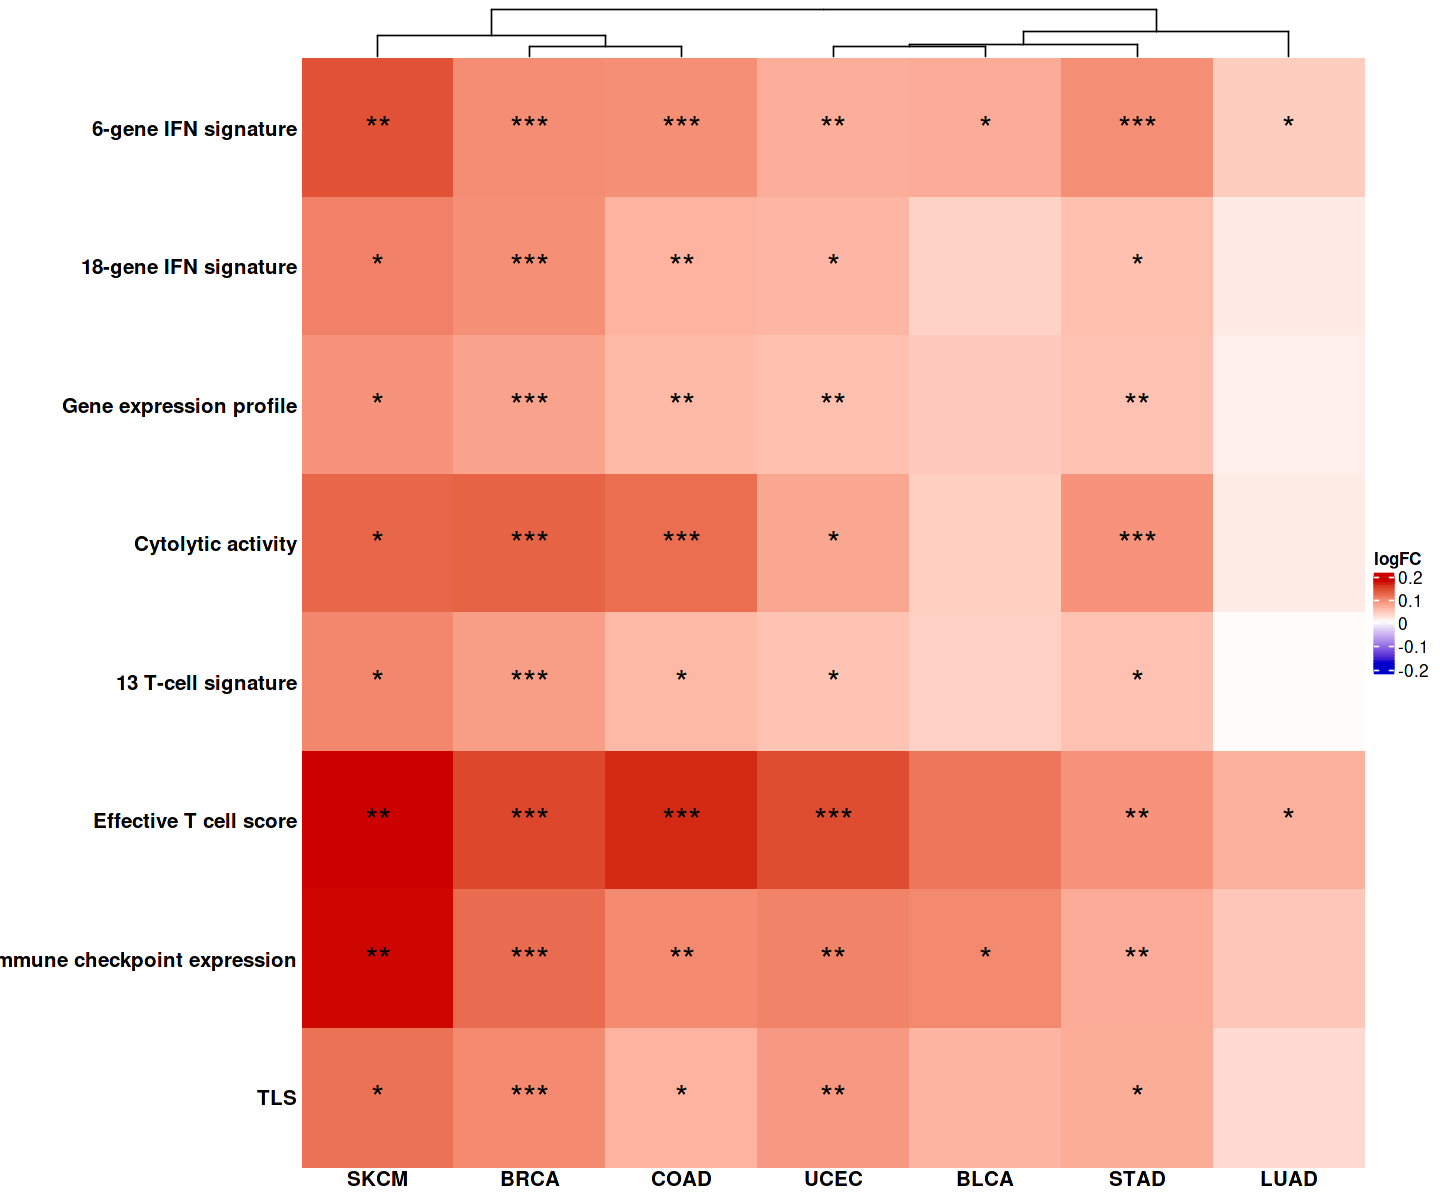

In [76]:
res = vector()
res_p = vector()
immune_module = "immune_pathway"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$mut)
  wt = intersect(colnames(TCGA_PanCancer[[cancer_type]][[immune_module]]),tmp_cohort$wt)
  res = cbind(res,log2(rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,mut])/rowMeans(TCGA_PanCancer[[cancer_type]][[immune_module]][,wt])))
  res_p_tmp = vector()
  for(i in rownames(res)){
    res_p_tmp = c(res_p_tmp,wilcox.test(TCGA_PanCancer[[cancer_type]][[immune_module]][i,mut],TCGA_PanCancer[[cancer_type]][[immune_module]][i,wt])$p.value)
  }
  res_p = cbind(res_p,res_p_tmp)
  
  
}
colnames(res) = CT
colnames(res_p) = CT
rownames(res_p) = rownames(res)
pname = rownames(TCGA_PanCancer$COAD$immune_pathway)

library(ComplexHeatmap)
library(circlize)
mv = max(c(abs(max(res[pname,],na.rm = T)),abs(min(res[pname,],na.rm = T))))
col_fun = colorRamp2(c(-mv, 0, mv), c("blue3", "white", "red3"))
options(repr.plot.height = 10, repr.plot.width = 12)
p = Heatmap(res[pname,],col = col_fun,cluster_rows = F,name = "logFC",
            row_names_gp = gpar(fontface = "bold",cex = 1),
            column_names_gp = gpar(fontface = "bold",cex = 1),
            row_names_side = "left",column_names_rot = 0,column_names_centered = TRUE,
            layer_fun = function(j, i, x, y, w, h, fill) {
              v = pindex(res_p[pname,], i, j)
              l = v <=0.05 & v > 0.01
                if(any(l)){
                    grid.text("*",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v <= 0.01 & v > 0.001
                if(any(l)){
                    grid.text("**",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v < 0.001 
                if(any(l)){
                   grid.text("***",x[l], y[l],gp = gpar(fontsize = 20)) 
                }
              
            }
           )

# pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/TME Signature/","Immune_Signature_Mean.pdf",sep = ""),width = 15,height = 10,onefile = FALSE)
print(p)
# dev.off()

### immune signature -- all

In [77]:
res = vector()
immune_module = "immune_infiltration"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
# CT = names(TCGA_PanCancer)
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(signature_score),tmp_cohort$mut)
  wt = intersect(colnames(signature_score),tmp_cohort$wt)
  tmp = cbind(rowMeans(signature_score[,mut]),rowMeans(signature_score[,wt]))
  colnames(tmp) = paste(cancer_type,c("Mutation","Wildtype"),sep = "_")
  # colnames(tmp) = c("Mutation","Wildtype")
  res = cbind(res,tmp)
  
}

# pname = c("Macrophages M0",
#           "Macrophages M1",
#           "Macrophages M2",
#           "Neutrophils",
#           "T cells CD8",
#           "Monocytes"
#          )
pname = rownames(signature_score)

for(i in pname){
  tmp_mat = reshape2::melt(res[i,])
  tmp_mat$mut_wt = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,2]
  tmp_mat$Cancer_type = do.call(rbind,strsplit(rownames(tmp_mat),"_"))[,1]
  tmp_mat$mut_wt = factor(tmp_mat$mut_wt,levels = c("Wildtype","Mutation"))
  
  tmp_mat2 = matrix(res[i,],ncol =2,byrow = T)
  
  tmp_p = wilcox.test(tmp_mat2[,1],tmp_mat2[,2],paired = T,alternative = "two.sided")$p.value
  
  pp = max(tmp_mat$value)
  options(repr.plot.height = 10, repr.plot.width = 10)
  p = ggplot(data = tmp_mat,)+
    geom_boxplot(mapping = aes(x = mut_wt,y = value),color = c("gray","gray"),show.legend = F,width=0.1)+
    geom_point(mapping = aes(x = mut_wt,y = value,color = Cancer_type),size = 3)+
    geom_line(aes(x = mut_wt,y = value,color = Cancer_type,group = Cancer_type))+
    annotate("text",x = 1.5,y = pp,label = paste("Wilcox : P value = ",round(tmp_p,digits = 4)),size = 4)+
    theme_classic()+
    ggtitle(label = i)+
    scale_color_manual(values = RColorBrewer::brewer.pal(9,"Set1")[1:length(CT)])+
    labs(y = "Mean expression level")+
    theme(
      axis.title.x = element_blank(),
      plot.title = element_text(hjust = 0.5,size = 20,face = "bold",family = "serif"),
      axis.text.x = element_text(size = 16,face = "bold",family = "serif"),
      axis.title.y = element_text(size = 16,face = "bold",family = "serif"),
      axis.text.y = element_text(size = 16,face = "bold",family = "serif")
    )
  
  pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/TME Signature/",paste(strsplit(i,split = " ")[[1]],collapse = "_"),"_Signature.pdf",sep = ""),width = 6,height = 6,onefile = FALSE)
  print(p)
  dev.off()
}

In [82]:
res = vector()
res_p = vector()
immune_module = "immune_pathway"
CT = c("BRCA","COAD","SKCM","STAD","UCEC","BLCA","LUAD")
for(cancer_type in CT){
  tmp_cohort = TCGA_cohort_cal_pm(TCGA = TCGA_PanCancer,cancer_type = cancer_type,pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",Mut_type = "All",Wild_type = "Wiltype")
  mut = intersect(colnames(signature_score),tmp_cohort$mut)
  wt = intersect(colnames(signature_score),tmp_cohort$wt)
  res = cbind(res,rowMeans(signature_score[,mut])-rowMeans(signature_score[,wt]))
  res_p_tmp = vector()
  for(i in rownames(res)){
    res_p_tmp = c(res_p_tmp,wilcox.test(signature_score[i,mut],signature_score[i,wt])$p.value)
  }
  res_p = cbind(res_p,res_p_tmp)
  
  
}
colnames(res) = CT
colnames(res_p) = CT
rownames(res_p) = rownames(res)
pname = rownames(signature_score)
# pname = c("Activated CD4 T cell","Activated CD8 T cell","Effector memeory CD8 T cell","Activated dendritic cell","Natural killer T cell")
# pheatmap::pheatmap(t(res[pname,]),
#                    cluster_rows = F,
#                    color = c(colorRampPalette(colors = c("blue3","white"))(500),
#                              colorRampPalette(colors = c("white","red3"))(500)),
#                    breaks = seq(from = -0.5,to = 0.5,by = 0.001))
library(ComplexHeatmap)
library(circlize)
mv = max(c(abs(max(res[pname,],na.rm = T)),abs(min(res[pname,],na.rm = T))))
col_fun = colorRamp2(c(-mv, 0, mv), c("blue3", "white", "red3"))
options(repr.plot.height = 10, repr.plot.width = 12)
p = Heatmap(res[pname,],col = col_fun,cluster_rows = T,name = "Diff",row_dend_side = "right",
            row_names_gp = gpar(fontface = "bold",cex = 1),
            column_names_gp = gpar(fontface = "bold",cex = 1),
            row_names_side = "left",column_names_rot = 0,column_names_centered = TRUE,
            layer_fun = function(j, i, x, y, w, h, fill) {
              v = pindex(res_p[pname,], i, j)
              l = v <=0.05 & v > 0.01
                if(any(l)){
                    grid.text("*",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v <= 0.01 & v > 0.001
                if(any(l)){
                    grid.text("**",x[l], y[l],gp = gpar(fontsize = 20))
                }
              
              l = v < 0.001 
                if(any(l)){
                   grid.text("***",x[l], y[l],gp = gpar(fontsize = 20)) 
                }
              
            }
           )

pdf(file = paste("Artical_Figure2/Figure 3/7.Cancer/TME Signature/","Immune_Signature_ssGSEA.pdf",sep = ""),width = 12,height = 10,onefile = FALSE)
print(p)
dev.off()

png 
  2